In [1]:
import torch
import numpy as np
import albumentations as A

# Đường dẫn file gốc và file mới
input_path = "/kaggle/input/backgound-eff-shap/backgrounds_dict_eff_shap.pt"
output_path = "/kaggle/working/backgrounds_dict_vit_shap.pt"

# Load background dict
background_dict = torch.load(input_path, map_location="cpu")

# Hàm resize 224x224 cho 1 ảnh
transform = A.Compose([A.Resize(224, 224)])

def resize_tensor(img_tensor):
    # img_tensor: (C, H, W)
    hwc = np.transpose(img_tensor.numpy(), (1, 2, 0))  # (H,W,C)
    hwc_resized = transform(image=hwc)["image"]
    chw = np.transpose(hwc_resized, (2, 0, 1))  # (C,H,W)
    return torch.tensor(chw, dtype=torch.float32)

# Resize toàn bộ dict
resized_dict = {}
for class_id, imgs in background_dict.items():
    resized_list = [resize_tensor(img) for img in imgs]
    resized_dict[class_id] = torch.stack(resized_list, dim=0)
    print(f"Class {class_id}: {imgs.shape} -> {resized_dict[class_id].shape}")

# Lưu ra file mới
torch.save(resized_dict, output_path)
print(f"✅ Saved resized backgrounds to {output_path}")


Class 0: torch.Size([150, 12, 120, 120]) -> torch.Size([150, 12, 224, 224])
Class 1: torch.Size([150, 12, 120, 120]) -> torch.Size([150, 12, 224, 224])
Class 2: torch.Size([150, 12, 120, 120]) -> torch.Size([150, 12, 224, 224])
Class 3: torch.Size([150, 12, 120, 120]) -> torch.Size([150, 12, 224, 224])
Class 4: torch.Size([150, 12, 120, 120]) -> torch.Size([150, 12, 224, 224])
Class 5: torch.Size([150, 12, 120, 120]) -> torch.Size([150, 12, 224, 224])
Class 6: torch.Size([150, 12, 120, 120]) -> torch.Size([150, 12, 224, 224])
Class 7: torch.Size([150, 12, 120, 120]) -> torch.Size([150, 12, 224, 224])
Class 8: torch.Size([150, 12, 120, 120]) -> torch.Size([150, 12, 224, 224])
Class 9: torch.Size([150, 12, 120, 120]) -> torch.Size([150, 12, 224, 224])
Class 10: torch.Size([150, 12, 120, 120]) -> torch.Size([150, 12, 224, 224])
Class 11: torch.Size([150, 12, 120, 120]) -> torch.Size([150, 12, 224, 224])
Class 12: torch.Size([150, 12, 120, 120]) -> torch.Size([150, 12, 224, 224])
Class 13:

In [2]:
!pip install rbo

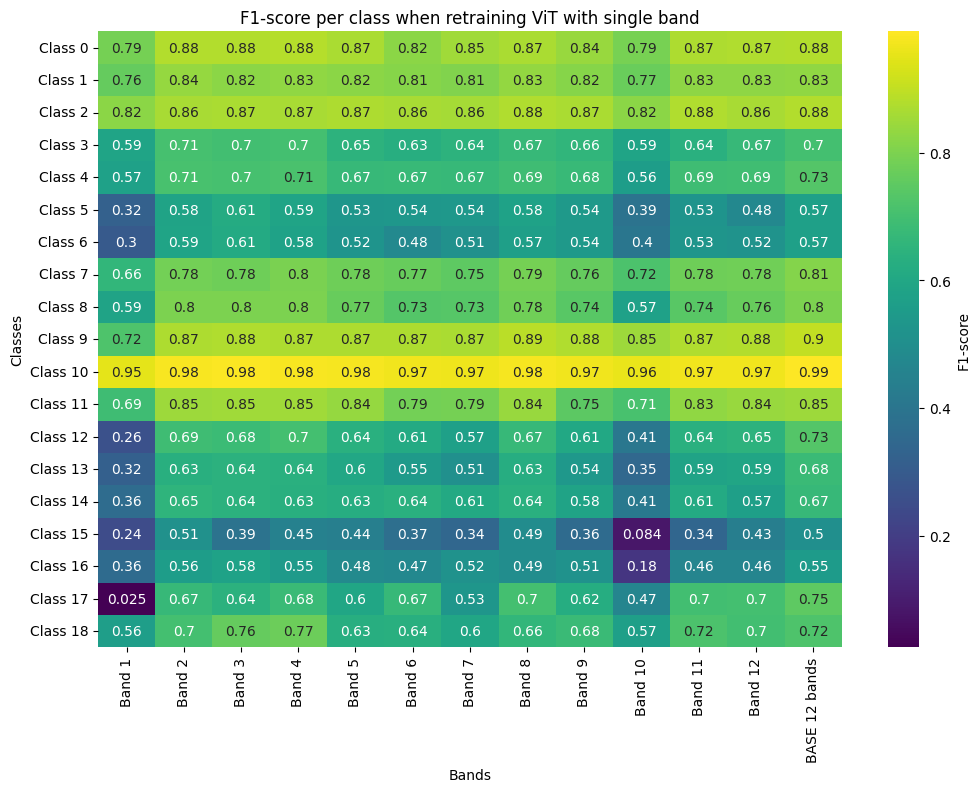

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# dữ liệu bạn đưa (mỗi list là f1 cho 19 class khi giữ lại 1 band và retrain)
data = {
    "Band 1": [0.787120, 0.762402, 0.823505, 0.590129, 0.572901, 0.321932, 0.295879, 0.661648, 0.585121, 0.721775, 0.952197, 0.688810, 0.263501, 0.316032, 0.362487, 0.244131, 0.359768, 0.025000, 0.563107],
    "Band 2": [0.877758, 0.835740, 0.864935, 0.706105, 0.710595, 0.584333, 0.588854, 0.784653, 0.801291, 0.869852, 0.982114, 0.849032, 0.691141, 0.633836, 0.652212, 0.510949, 0.559486, 0.671756, 0.701031],
    "Band 3": [0.878611, 0.823816, 0.868370, 0.697647, 0.704335, 0.613433, 0.609484, 0.778325, 0.798572, 0.876471, 0.983315, 0.851042, 0.682403, 0.643180, 0.641929, 0.391667, 0.582313, 0.641791, 0.761905],
    "Band 4": [0.880830, 0.829851, 0.865080, 0.701837, 0.712886, 0.590099, 0.579897, 0.796147, 0.799074, 0.871620, 0.978930, 0.854237, 0.703416, 0.637168, 0.634633, 0.445344, 0.548023, 0.677419, 0.772277],
    "Band 5": [0.868510, 0.821907, 0.870050, 0.646021, 0.672417, 0.530340, 0.524415, 0.777679, 0.767147, 0.871784, 0.978243, 0.836209, 0.637006, 0.601583, 0.628099, 0.438462, 0.481416, 0.597015, 0.631579],
    "Band 6": [0.822605, 0.814056, 0.863466, 0.631415, 0.673517, 0.535756, 0.480371, 0.765068, 0.732911, 0.871163, 0.968292, 0.785909, 0.611354, 0.546845, 0.636364, 0.372881, 0.473684, 0.671329, 0.635514],
    "Band 7": [0.852318, 0.808066, 0.861593, 0.644422, 0.672472, 0.537982, 0.509194, 0.751547, 0.733749, 0.866002, 0.965872, 0.789872, 0.571300, 0.506778, 0.605960, 0.342342, 0.516035, 0.530303, 0.596491],
    "Band 8": [0.866212, 0.834288, 0.876409, 0.670756, 0.691554, 0.582646, 0.565517, 0.788673, 0.782298, 0.888611, 0.977576, 0.840565, 0.671987, 0.626263, 0.637282, 0.488722, 0.494737, 0.702290, 0.660000],
    "Band 9": [0.842253, 0.816444, 0.866982, 0.656291, 0.676810, 0.544875, 0.543596, 0.762754, 0.740525, 0.876005, 0.967846, 0.746483, 0.605459, 0.540592, 0.582951, 0.359375, 0.513557, 0.622222, 0.679612],
    "Band 10": [0.793380, 0.769831, 0.821149, 0.589879, 0.557025, 0.393036, 0.403392, 0.716708, 0.574906, 0.848458, 0.957869, 0.709787, 0.408103, 0.348684, 0.413866, 0.084211, 0.175055, 0.465116, 0.565217],
    "Band 11": [0.871568, 0.827270, 0.876409, 0.638907, 0.689326, 0.525565, 0.527255, 0.775905, 0.739953, 0.873632, 0.970620, 0.831086, 0.635990, 0.586268, 0.612737, 0.338843, 0.462585, 0.697674, 0.718447],
    "Band 12": [0.874694, 0.827565, 0.863551, 0.672749, 0.692965, 0.475380, 0.521204, 0.780298, 0.764472, 0.877796, 0.970382, 0.841945, 0.646852, 0.593446, 0.567694, 0.434457, 0.463122, 0.700730, 0.699029],
    "BASE 12 bands": [0.88, 0.83, 0.88, 0.70, 0.73, 0.57, 0.57, 0.81, 0.80, 0.90, 0.99, 0.85, 0.73, 0.68, 0.67, 0.50, 0.55, 0.75, 0.72]
}

# tạo DataFrame: row = class, col = band
df = pd.DataFrame(data)
df.index = [f"Class {i}" for i in range(19)]

plt.figure(figsize=(12, 8))
sns.heatmap(df, annot=True, cmap="viridis", cbar_kws={'label': 'F1-score'})
plt.title("F1-score per class when retraining ViT with single band")
plt.xlabel("Bands")
plt.ylabel("Classes")
plt.show()



CLASS 0

F1-Base: 0.88

Top bands by LIME:     ['B8', 'B7', 'B12', 'B3', 'B9']
Top bands by SHAP:     ['B3', 'B7', 'B12', 'B8', 'B4']
Top bands by Baseline (low → important): ['B3', 'B12', 'B7', 'B8', 'B11']

Same-Sign Score (LIME vs SHAP):     0.8333333333333334

Spearman correlation (LIME vs SHAP):     0.692
Spearman correlation (LIME vs Baseline): 0.599
Spearman correlation (SHAP vs Baseline): 0.515

RBO (LIME vs SHAP):     0.224
RBO (LIME vs Baseline): 0.179
RBO (SHAP vs Baseline): 0.351

Intersection Ratio (Baseline ∩ (LIME ∪ SHAP)): 0.667

Jaccard Similarity (LIME vs SHAP):     0.667
Jaccard Similarity (LIME vs Baseline): 0.667
Jaccard Similarity (SHAP vs Baseline): 0.667


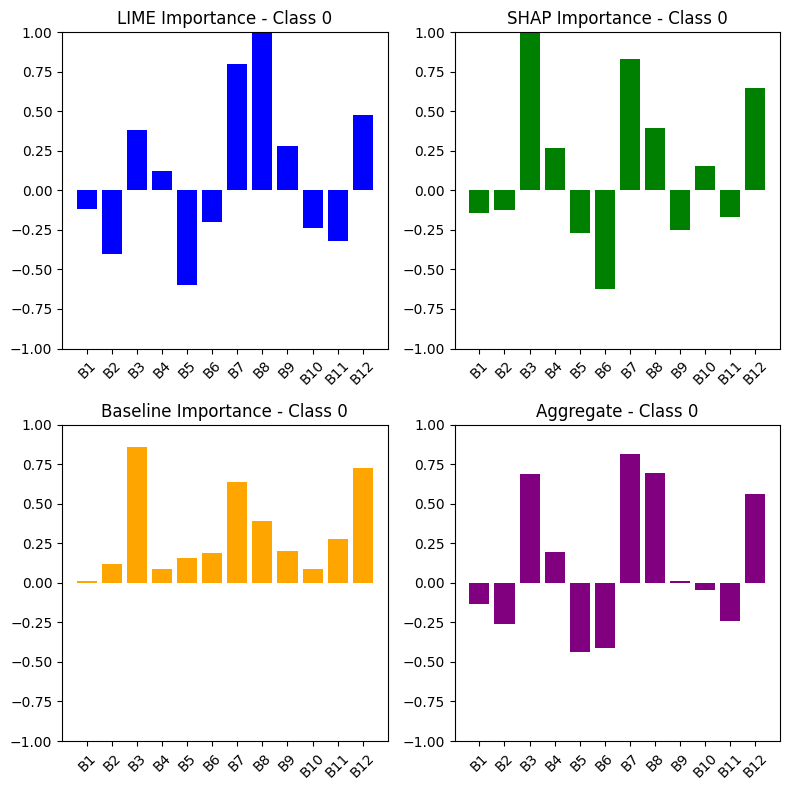

Spearman correlation (Avg vs Baseline): [0.5674264393540605]
RBO (Avg vs Baseline): [0.179388]
Jaccard Similarity (Avg vs Baseline): [0.6666666666666666]
Spearman 0.567 ± 0.000
RBO 0.179 ± 0.000
Jaccard 0.667 ± 0.000

CLASS 1

F1-Base: 0.85

Top bands by LIME:     ['B8', 'B11', 'B9', 'B2', 'B1']
Top bands by SHAP:     ['B8', 'B12', 'B9', 'B3', 'B10']
Top bands by Baseline (low → important): ['B9', 'B8', 'B7', 'B6', 'B11']

Same-Sign Score (LIME vs SHAP):     0.5

Spearman correlation (LIME vs SHAP):     0.102
Spearman correlation (LIME vs Baseline): 0.273
Spearman correlation (SHAP vs Baseline): 0.203

RBO (LIME vs SHAP):     0.262
RBO (LIME vs Baseline): 0.175
RBO (SHAP vs Baseline): 0.162

Intersection Ratio (Baseline ∩ (LIME ∪ SHAP)): 0.375

Jaccard Similarity (LIME vs SHAP):     0.250
Jaccard Similarity (LIME vs Baseline): 0.429
Jaccard Similarity (SHAP vs Baseline): 0.250


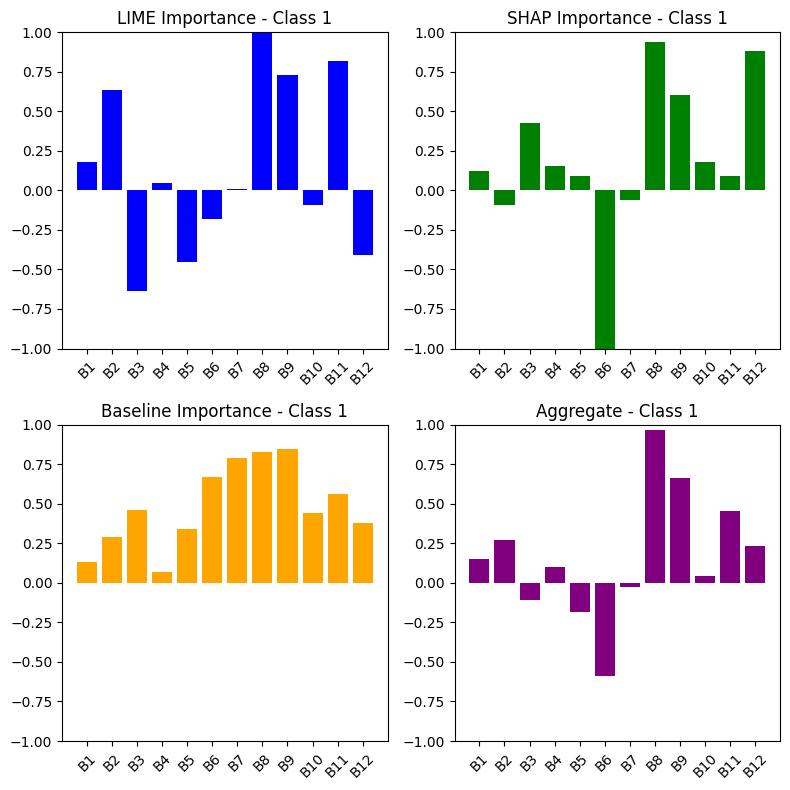

Spearman correlation (Avg vs Baseline): [0.5674264393540605, 0.22377622377622378]
RBO (Avg vs Baseline): [0.179388, 0.21981599999999993]
Jaccard Similarity (Avg vs Baseline): [0.6666666666666666, 0.42857142857142855]
Spearman 0.396 ± 0.172
RBO 0.200 ± 0.020
Jaccard 0.548 ± 0.119

CLASS 2

F1-Base: 0.89

Top bands by LIME:     ['B8', 'B6', 'B2', 'B11', 'B9']
Top bands by SHAP:     ['B11', 'B3', 'B9', 'B8', 'B10']
Top bands by Baseline (low → important): ['B6', 'B9', 'B3', 'B7', 'B5']

Same-Sign Score (LIME vs SHAP):     0.4166666666666667

Spearman correlation (LIME vs SHAP):     -0.189
Spearman correlation (LIME vs Baseline): 0.086
Spearman correlation (SHAP vs Baseline): -0.007

RBO (LIME vs SHAP):     0.076
RBO (LIME vs Baseline): 0.116
RBO (SHAP vs Baseline): 0.117

Intersection Ratio (Baseline ∩ (LIME ∪ SHAP)): 0.429

Jaccard Similarity (LIME vs SHAP):     0.429
Jaccard Similarity (LIME vs Baseline): 0.250
Jaccard Similarity (SHAP vs Baseline): 0.250


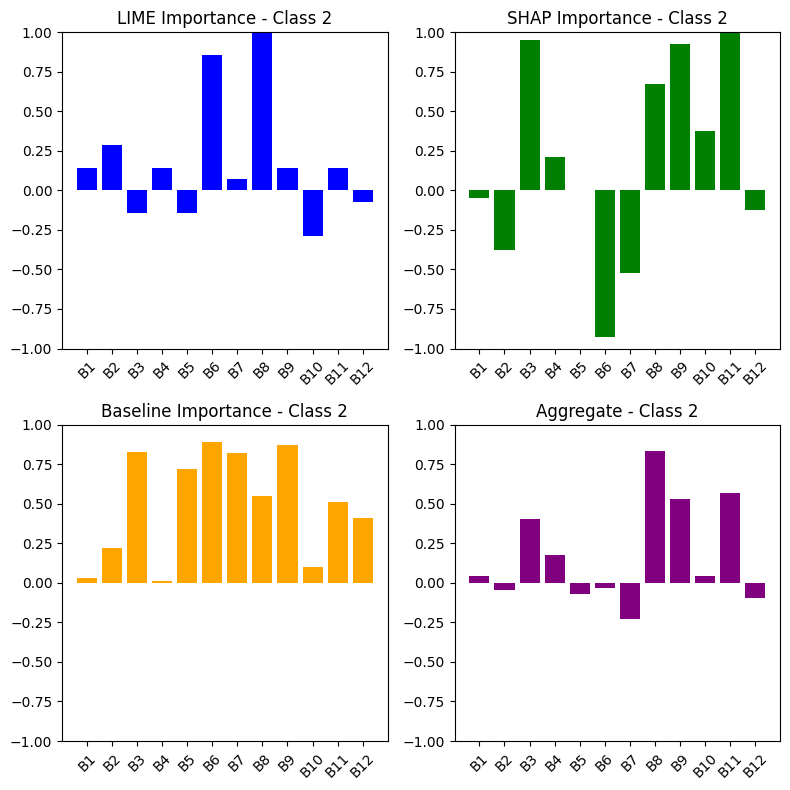

Spearman correlation (Avg vs Baseline): [0.5674264393540605, 0.22377622377622378, 0.013986013986013986]
RBO (Avg vs Baseline): [0.179388, 0.21981599999999993, 0.089694]
Jaccard Similarity (Avg vs Baseline): [0.6666666666666666, 0.42857142857142855, 0.25]
Spearman 0.268 ± 0.228
RBO 0.163 ± 0.054
Jaccard 0.448 ± 0.171

CLASS 3

F1-Base: 0.67

Top bands by LIME:     ['B11', 'B4', 'B8', 'B5', 'B9']
Top bands by SHAP:     ['B3', 'B8', 'B7', 'B12', 'B4']
Top bands by Baseline (low → important): ['B6', 'B5', 'B3', 'B7', 'B12']

Same-Sign Score (LIME vs SHAP):     0.3333333333333333

Spearman correlation (LIME vs SHAP):     -0.070
Spearman correlation (LIME vs Baseline): -0.445
Spearman correlation (SHAP vs Baseline): -0.106

RBO (LIME vs SHAP):     0.071
RBO (LIME vs Baseline): 0.031
RBO (SHAP vs Baseline): 0.103

Intersection Ratio (Baseline ∩ (LIME ∪ SHAP)): 0.500

Jaccard Similarity (LIME vs SHAP):     0.250
Jaccard Similarity (LIME vs Baseline): 0.111
Jaccard Similarity (SHAP vs Baseline)

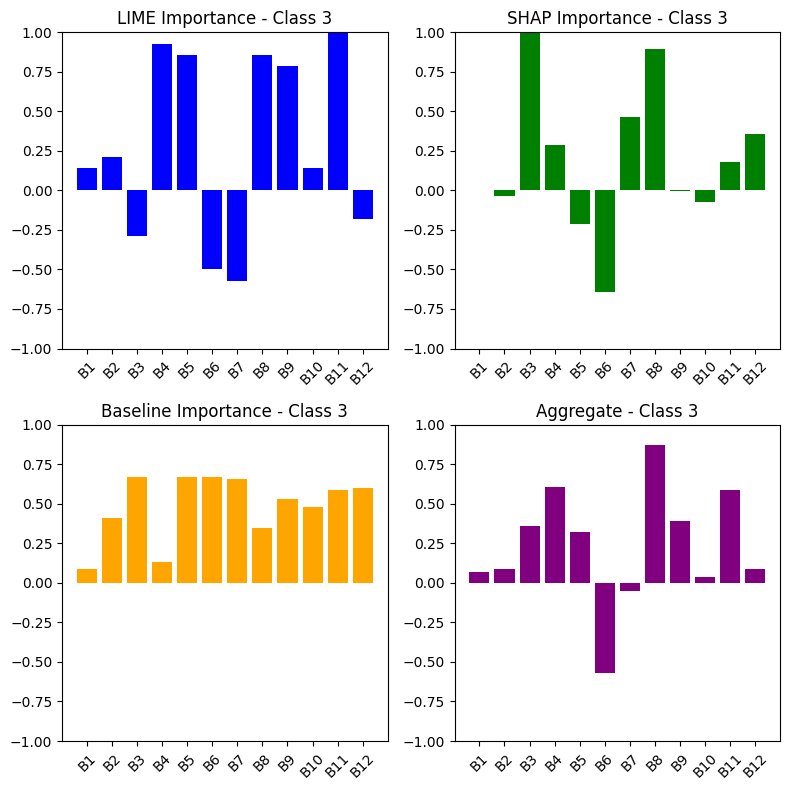

Spearman correlation (Avg vs Baseline): [0.5674264393540605, 0.22377622377622378, 0.013986013986013986, -0.30986683868975945]
RBO (Avg vs Baseline): [0.179388, 0.21981599999999993, 0.089694, 0.013121999999999998]
Jaccard Similarity (Avg vs Baseline): [0.6666666666666666, 0.42857142857142855, 0.25, 0.1111111111111111]
Spearman 0.124 ± 0.319
RBO 0.126 ± 0.080
Jaccard 0.364 ± 0.208

CLASS 4

F1-Base: 0.73

Top bands by LIME:     ['B11', 'B9', 'B8', 'B1', 'B4']
Top bands by SHAP:     ['B11', 'B3', 'B8', 'B9', 'B10']
Top bands by Baseline (low → important): ['B11', 'B9', 'B7', 'B6', 'B8']

Same-Sign Score (LIME vs SHAP):     0.5

Spearman correlation (LIME vs SHAP):     0.431
Spearman correlation (LIME vs Baseline): 0.265
Spearman correlation (SHAP vs Baseline): 0.331

RBO (LIME vs SHAP):     0.293
RBO (LIME vs Baseline): 0.320
RBO (SHAP vs Baseline): 0.248

Intersection Ratio (Baseline ∩ (LIME ∪ SHAP)): 0.429

Jaccard Similarity (LIME vs SHAP):     0.429
Jaccard Similarity (LIME vs Baselin

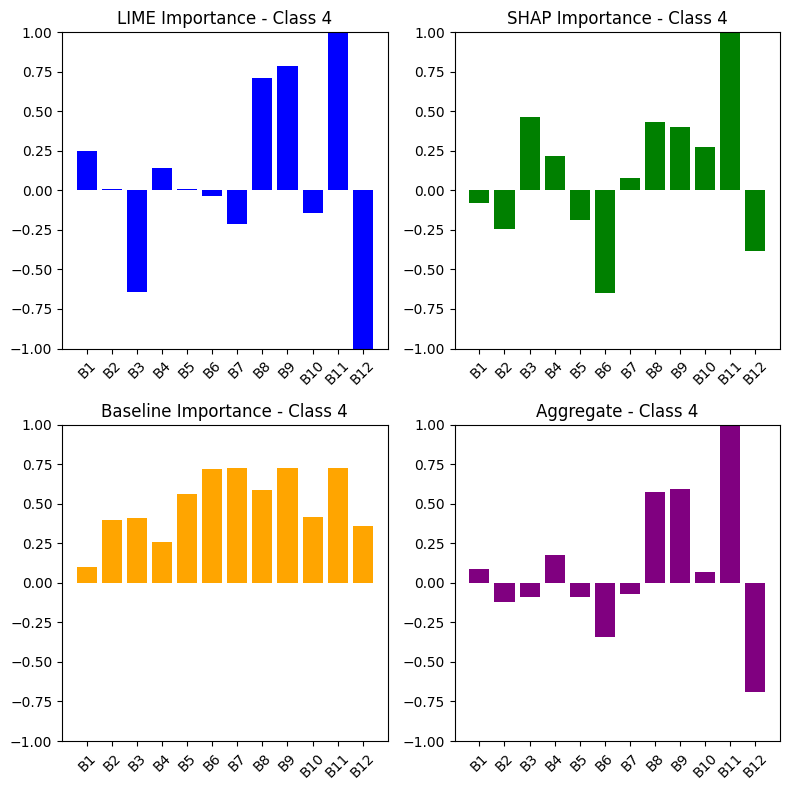

Spearman correlation (Avg vs Baseline): [0.5674264393540605, 0.22377622377622378, 0.013986013986013986, -0.30986683868975945, 0.3380365512979194]
RBO (Avg vs Baseline): [0.179388, 0.21981599999999993, 0.089694, 0.013121999999999998, 0.31981599999999993]
Jaccard Similarity (Avg vs Baseline): [0.6666666666666666, 0.42857142857142855, 0.25, 0.1111111111111111, 0.42857142857142855]
Spearman 0.167 ± 0.298
RBO 0.164 ± 0.106
Jaccard 0.377 ± 0.188

CLASS 5

F1-Base: 0.58

Top bands by LIME:     ['B8', 'B3', 'B12', 'B11', 'B9']
Top bands by SHAP:     ['B3', 'B8', 'B12', 'B7', 'B4']
Top bands by Baseline (low → important): ['B6', 'B5', 'B3', 'B7', 'B11']

Same-Sign Score (LIME vs SHAP):     0.8333333333333334

Spearman correlation (LIME vs SHAP):     0.782
Spearman correlation (LIME vs Baseline): -0.111
Spearman correlation (SHAP vs Baseline): -0.043

RBO (LIME vs SHAP):     0.265
RBO (LIME vs Baseline): 0.071
RBO (SHAP vs Baseline): 0.090

Intersection Ratio (Baseline ∩ (LIME ∪ SHAP)): 0.429

J

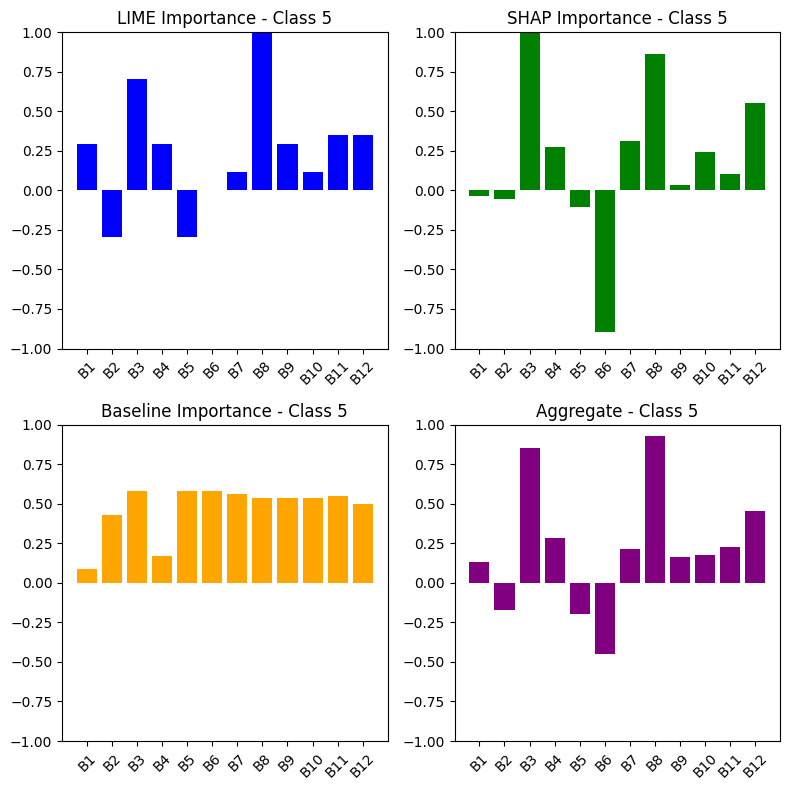

Spearman correlation (Avg vs Baseline): [0.5674264393540605, 0.22377622377622378, 0.013986013986013986, -0.30986683868975945, 0.3380365512979194, -0.12057950662162813]
RBO (Avg vs Baseline): [0.179388, 0.21981599999999993, 0.089694, 0.013121999999999998, 0.31981599999999993, 0.07146899999999999]
Jaccard Similarity (Avg vs Baseline): [0.6666666666666666, 0.42857142857142855, 0.25, 0.1111111111111111, 0.42857142857142855, 0.25]
Spearman 0.119 ± 0.292
RBO 0.149 ± 0.103
Jaccard 0.356 ± 0.178

CLASS 6

F1-Base: 0.54

Top bands by LIME:     ['B3', 'B12', 'B8', 'B4', 'B11']
Top bands by SHAP:     ['B3', 'B8', 'B11', 'B12', 'B4']
Top bands by Baseline (low → important): ['B12', 'B11', 'B10', 'B8', 'B7']

Same-Sign Score (LIME vs SHAP):     0.8333333333333334

Spearman correlation (LIME vs SHAP):     0.874
Spearman correlation (LIME vs Baseline): 0.303
Spearman correlation (SHAP vs Baseline): 0.233

RBO (LIME vs SHAP):     0.319
RBO (LIME vs Baseline): 0.148
RBO (SHAP vs Baseline): 0.121

Inter

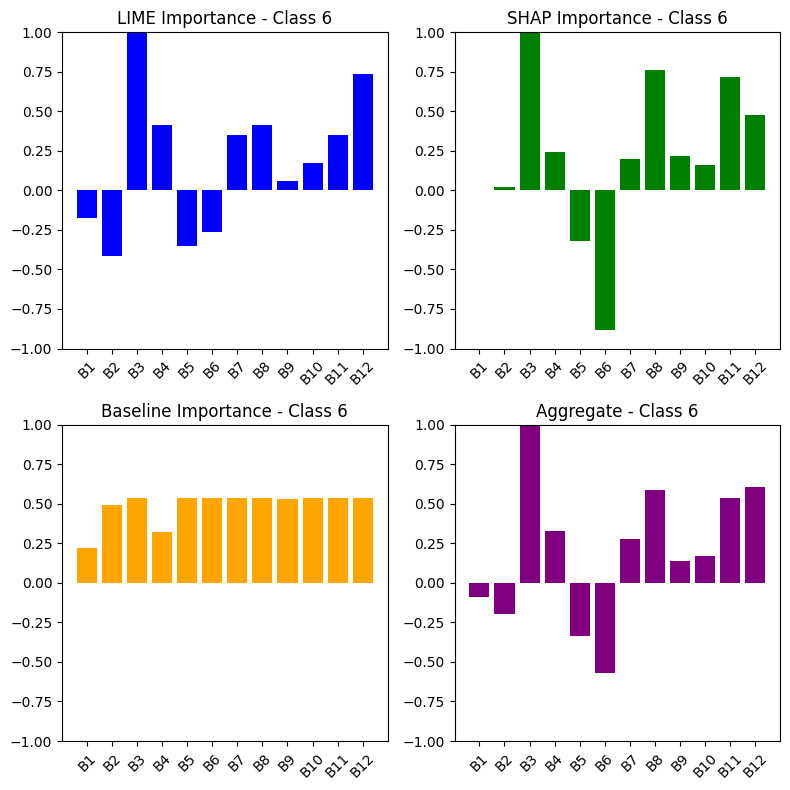

Spearman correlation (Avg vs Baseline): [0.5674264393540605, 0.22377622377622378, 0.013986013986013986, -0.30986683868975945, 0.3380365512979194, -0.12057950662162813, 0.29123216499055327]
RBO (Avg vs Baseline): [0.179388, 0.21981599999999993, 0.089694, 0.013121999999999998, 0.31981599999999993, 0.07146899999999999, 0.16604099999999997]
Jaccard Similarity (Avg vs Baseline): [0.6666666666666666, 0.42857142857142855, 0.25, 0.1111111111111111, 0.42857142857142855, 0.25, 0.42857142857142855]
Spearman 0.143 ± 0.277
RBO 0.151 ± 0.095
Jaccard 0.366 ± 0.166

CLASS 7

F1-Base: 0.79

Top bands by LIME:     ['B8', 'B11', 'B9', 'B10', 'B7']
Top bands by SHAP:     ['B8', 'B7', 'B3', 'B12', 'B4']
Top bands by Baseline (low → important): ['B11', 'B3', 'B9', 'B5', 'B7']

Same-Sign Score (LIME vs SHAP):     0.9166666666666666

Spearman correlation (LIME vs SHAP):     0.531
Spearman correlation (LIME vs Baseline): 0.259
Spearman correlation (SHAP vs Baseline): 0.263

RBO (LIME vs SHAP):     0.216
RBO (L

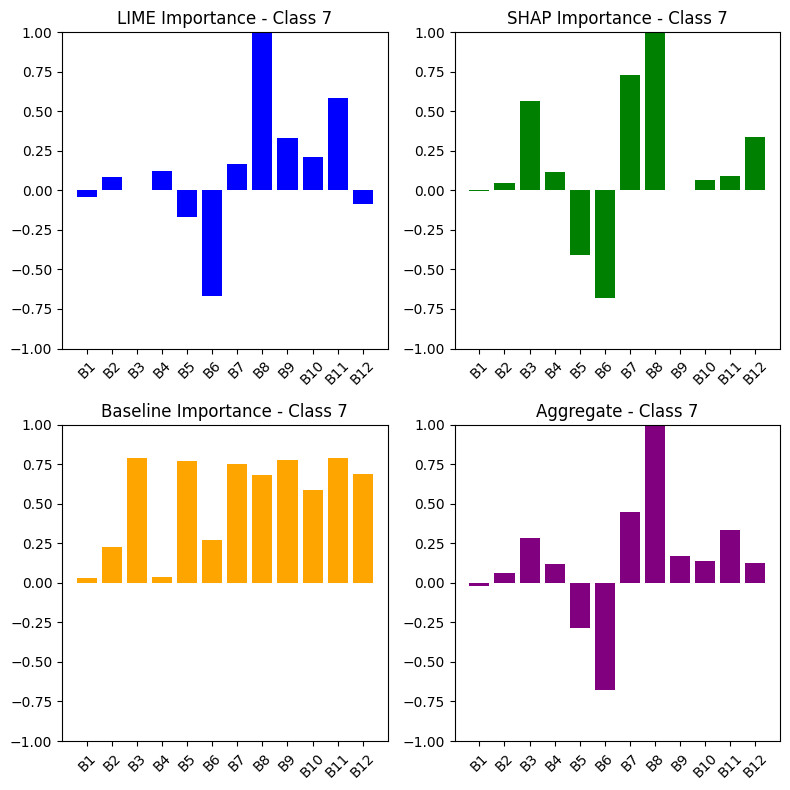

Spearman correlation (Avg vs Baseline): [0.5674264393540605, 0.22377622377622378, 0.013986013986013986, -0.30986683868975945, 0.3380365512979194, -0.12057950662162813, 0.29123216499055327, 0.5288974835954515]
RBO (Avg vs Baseline): [0.179388, 0.21981599999999993, 0.089694, 0.013121999999999998, 0.31981599999999993, 0.07146899999999999, 0.16604099999999997, 0.11593799999999999]
Jaccard Similarity (Avg vs Baseline): [0.6666666666666666, 0.42857142857142855, 0.25, 0.1111111111111111, 0.42857142857142855, 0.25, 0.42857142857142855, 0.6666666666666666]
Spearman 0.192 ± 0.289
RBO 0.147 ± 0.090
Jaccard 0.404 ± 0.185

CLASS 8

F1-Base: 0.81

Top bands by LIME:     ['B2', 'B11', 'B6', 'B4', 'B7']
Top bands by SHAP:     ['B2', 'B8', 'B12', 'B3', 'B7']
Top bands by Baseline (low → important): ['B6', 'B7', 'B3', 'B12', 'B11']

Same-Sign Score (LIME vs SHAP):     0.75

Spearman correlation (LIME vs SHAP):     0.329
Spearman correlation (LIME vs Baseline): 0.182
Spearman correlation (SHAP vs Baselin

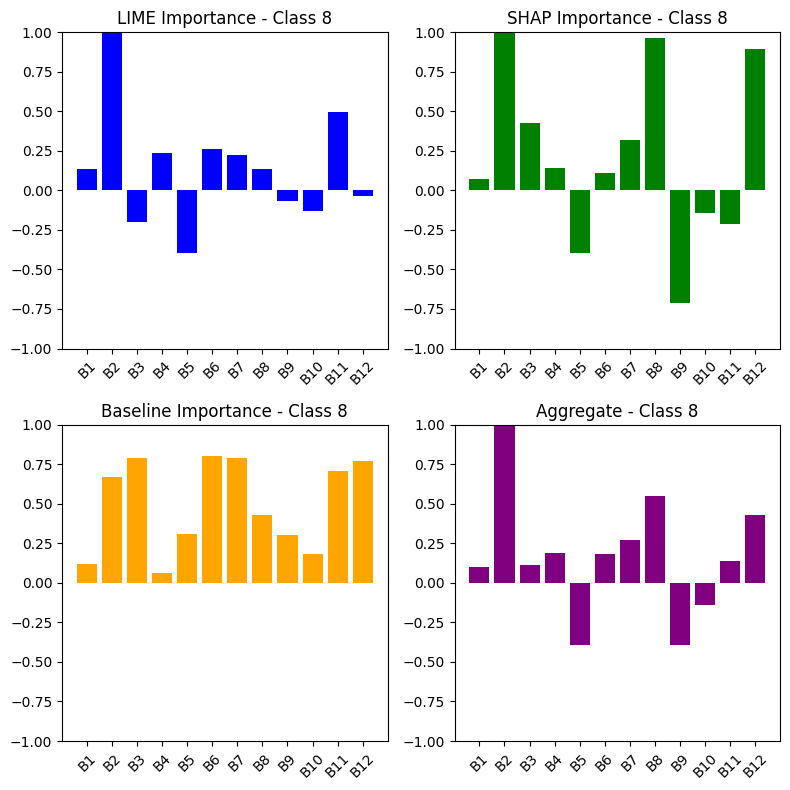

Spearman correlation (Avg vs Baseline): [0.5674264393540605, 0.22377622377622378, 0.013986013986013986, -0.30986683868975945, 0.3380365512979194, -0.12057950662162813, 0.29123216499055327, 0.5288974835954515, 0.35026323416917315]
RBO (Avg vs Baseline): [0.179388, 0.21981599999999993, 0.089694, 0.013121999999999998, 0.31981599999999993, 0.07146899999999999, 0.16604099999999997, 0.11593799999999999, 0.062694]
Jaccard Similarity (Avg vs Baseline): [0.6666666666666666, 0.42857142857142855, 0.25, 0.1111111111111111, 0.42857142857142855, 0.25, 0.42857142857142855, 0.6666666666666666, 0.25]
Spearman 0.209 ± 0.277
RBO 0.138 ± 0.089
Jaccard 0.387 ± 0.181

CLASS 9

F1-Base: 0.89

Top bands by LIME:     ['B10', 'B3', 'B8', 'B11', 'B2']
Top bands by SHAP:     ['B8', 'B9', 'B7', 'B11', 'B2']
Top bands by Baseline (low → important): ['B8', 'B2', 'B3', 'B12', 'B7']

Same-Sign Score (LIME vs SHAP):     0.8333333333333334

Spearman correlation (LIME vs SHAP):     0.337
Spearman correlation (LIME vs Bas

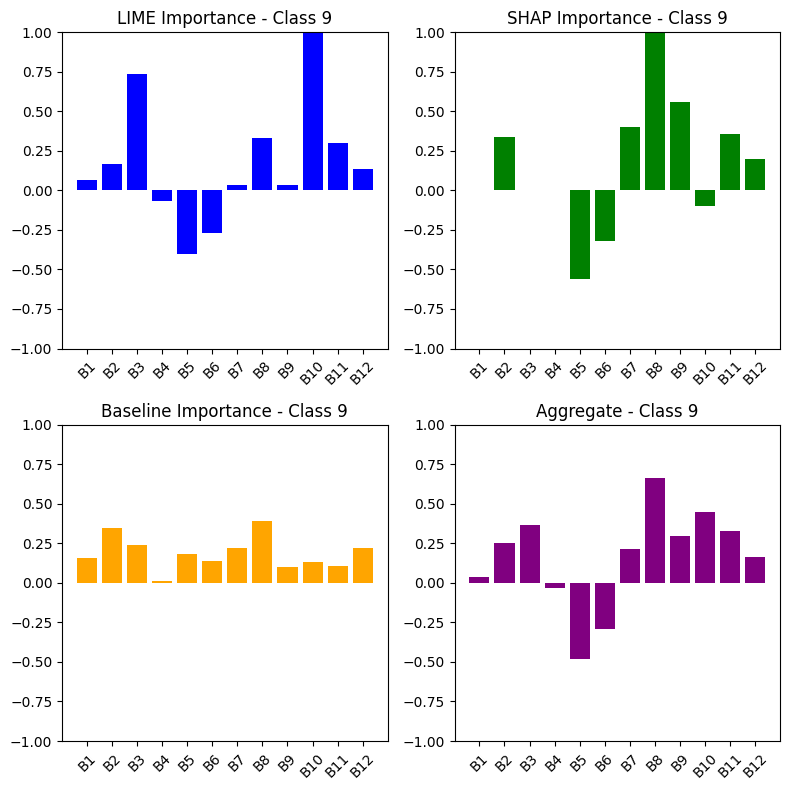

Spearman correlation (Avg vs Baseline): [0.5674264393540605, 0.22377622377622378, 0.013986013986013986, -0.30986683868975945, 0.3380365512979194, -0.12057950662162813, 0.29123216499055327, 0.5288974835954515, 0.35026323416917315, 0.26970269031026334]
RBO (Avg vs Baseline): [0.179388, 0.21981599999999993, 0.089694, 0.013121999999999998, 0.31981599999999993, 0.07146899999999999, 0.16604099999999997, 0.11593799999999999, 0.062694, 0.2616939999999999]
Jaccard Similarity (Avg vs Baseline): [0.6666666666666666, 0.42857142857142855, 0.25, 0.1111111111111111, 0.42857142857142855, 0.25, 0.42857142857142855, 0.6666666666666666, 0.25, 0.25]
Spearman 0.215 ± 0.263
RBO 0.150 ± 0.092
Jaccard 0.373 ± 0.176

CLASS 10

F1-Base: 0.98

Top bands by LIME:     ['B2', 'B1', 'B5', 'B4', 'B10']
Top bands by SHAP:     ['B8', 'B7', 'B11', 'B9', 'B12']
Top bands by Baseline (low → important): ['B2', 'B11', 'B1', 'B3', 'B5']

Same-Sign Score (LIME vs SHAP):     0.25

Spearman correlation (LIME vs SHAP):     -0.77

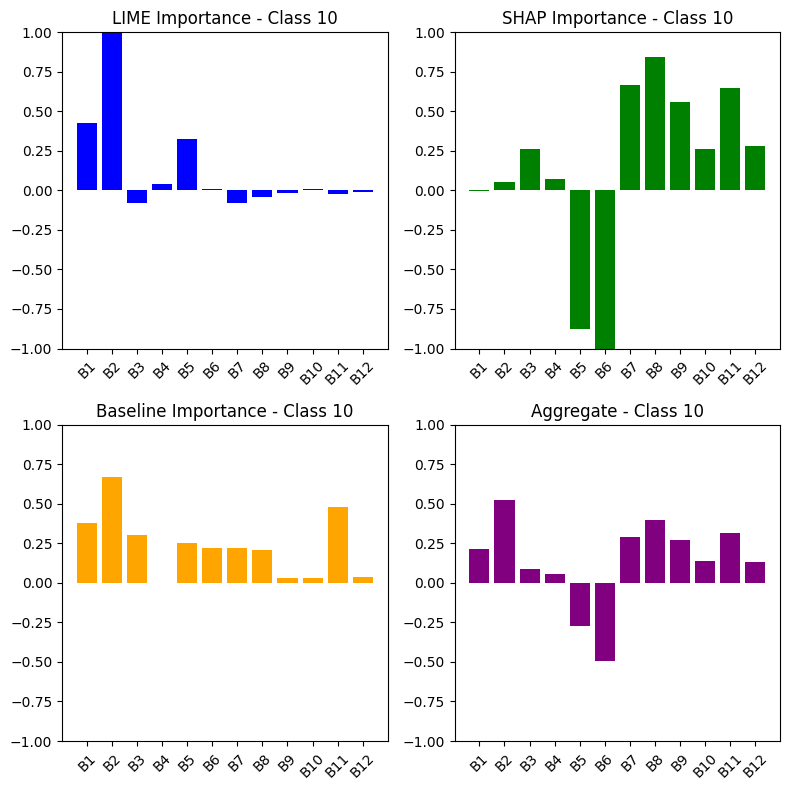

Spearman correlation (Avg vs Baseline): [0.5674264393540605, 0.22377622377622378, 0.013986013986013986, -0.30986683868975945, 0.3380365512979194, -0.12057950662162813, 0.29123216499055327, 0.5288974835954515, 0.35026323416917315, 0.26970269031026334, 0.32982659173657675]
RBO (Avg vs Baseline): [0.179388, 0.21981599999999993, 0.089694, 0.013121999999999998, 0.31981599999999993, 0.07146899999999999, 0.16604099999999997, 0.11593799999999999, 0.062694, 0.2616939999999999, 0.2616939999999999]
Jaccard Similarity (Avg vs Baseline): [0.6666666666666666, 0.42857142857142855, 0.25, 0.1111111111111111, 0.42857142857142855, 0.25, 0.42857142857142855, 0.6666666666666666, 0.25, 0.25, 0.25]
Spearman 0.226 ± 0.253
RBO 0.160 ± 0.093
Jaccard 0.362 ± 0.172

CLASS 11

F1-Base: 0.84

Top bands by LIME:     ['B12', 'B3', 'B4', 'B11', 'B6']
Top bands by SHAP:     ['B11', 'B4', 'B3', 'B7', 'B12']
Top bands by Baseline (low → important): ['B12', 'B11', 'B7', 'B6', 'B3']

Same-Sign Score (LIME vs SHAP):     0.7

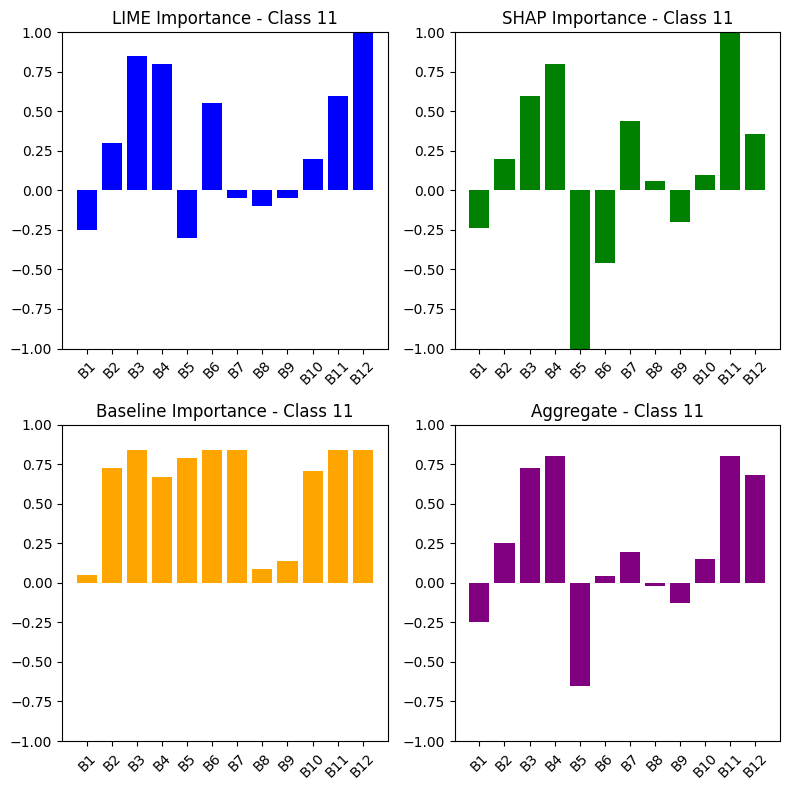

Spearman correlation (Avg vs Baseline): [0.5674264393540605, 0.22377622377622378, 0.013986013986013986, -0.30986683868975945, 0.3380365512979194, -0.12057950662162813, 0.29123216499055327, 0.5288974835954515, 0.35026323416917315, 0.26970269031026334, 0.32982659173657675, 0.49394166352926405]
RBO (Avg vs Baseline): [0.179388, 0.21981599999999993, 0.089694, 0.013121999999999998, 0.31981599999999993, 0.07146899999999999, 0.16604099999999997, 0.11593799999999999, 0.062694, 0.2616939999999999, 0.2616939999999999, 0.14781599999999998]
Jaccard Similarity (Avg vs Baseline): [0.6666666666666666, 0.42857142857142855, 0.25, 0.1111111111111111, 0.42857142857142855, 0.25, 0.42857142857142855, 0.6666666666666666, 0.25, 0.25, 0.25, 0.42857142857142855]
Spearman 0.248 ± 0.254
RBO 0.159 ± 0.089
Jaccard 0.367 ± 0.166

CLASS 12

F1-Base: 0.73

Top bands by LIME:     ['B11', 'B12', 'B4', 'B8', 'B7']
Top bands by SHAP:     ['B3', 'B12', 'B8', 'B4', 'B5']
Top bands by Baseline (low → important): ['B12', 'B8

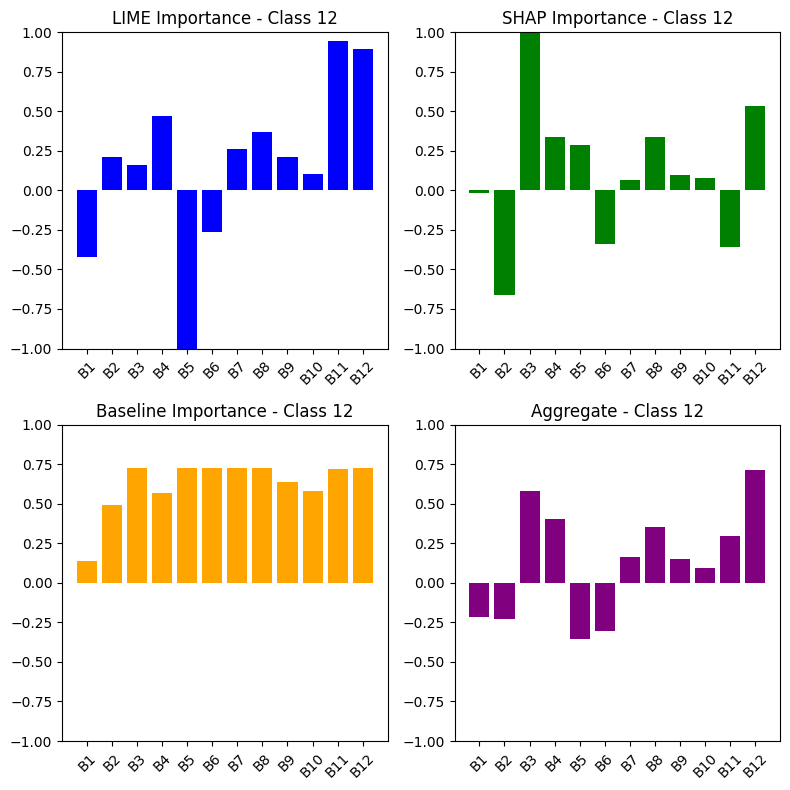

Spearman correlation (Avg vs Baseline): [0.5674264393540605, 0.22377622377622378, 0.013986013986013986, -0.30986683868975945, 0.3380365512979194, -0.12057950662162813, 0.29123216499055327, 0.5288974835954515, 0.35026323416917315, 0.26970269031026334, 0.32982659173657675, 0.49394166352926405, 0.22393984489839652]
RBO (Avg vs Baseline): [0.179388, 0.21981599999999993, 0.089694, 0.013121999999999998, 0.31981599999999993, 0.07146899999999999, 0.16604099999999997, 0.11593799999999999, 0.062694, 0.2616939999999999, 0.2616939999999999, 0.14781599999999998, 0.23469399999999996]
Jaccard Similarity (Avg vs Baseline): [0.6666666666666666, 0.42857142857142855, 0.25, 0.1111111111111111, 0.42857142857142855, 0.25, 0.42857142857142855, 0.6666666666666666, 0.25, 0.25, 0.25, 0.42857142857142855, 0.25]
Spearman 0.246 ± 0.244
RBO 0.165 ± 0.088
Jaccard 0.358 ± 0.162

CLASS 13

F1-Base: 0.67

Top bands by LIME:     ['B10', 'B11', 'B9', 'B2', 'B5']
Top bands by SHAP:     ['B3', 'B11', 'B9', 'B8', 'B10']
Top

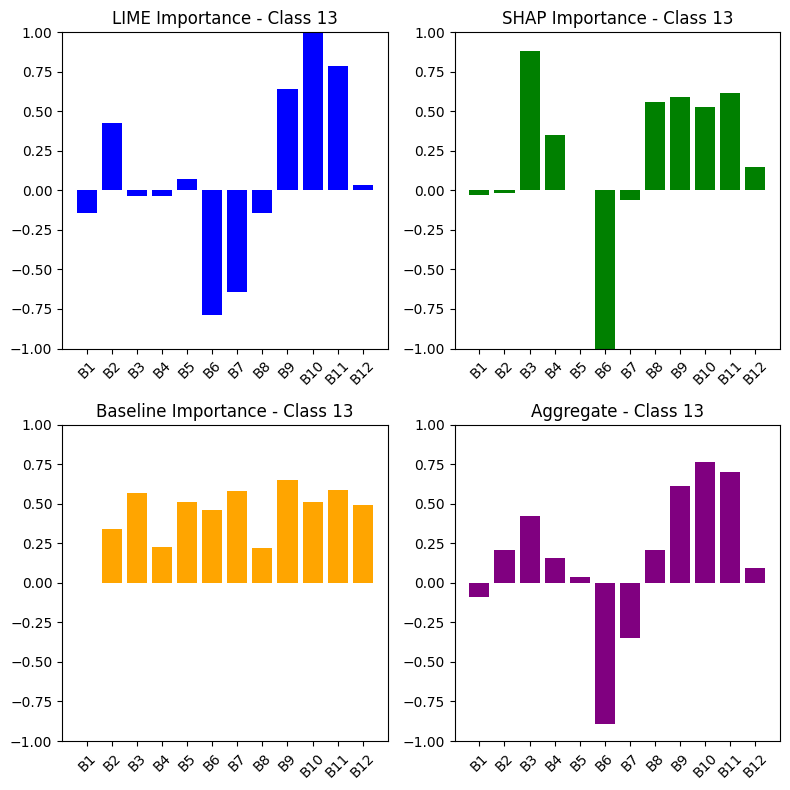

Spearman correlation (Avg vs Baseline): [0.5674264393540605, 0.22377622377622378, 0.013986013986013986, -0.30986683868975945, 0.3380365512979194, -0.12057950662162813, 0.29123216499055327, 0.5288974835954515, 0.35026323416917315, 0.26970269031026334, 0.32982659173657675, 0.49394166352926405, 0.22393984489839652, 0.38528955758609046]
RBO (Avg vs Baseline): [0.179388, 0.21981599999999993, 0.089694, 0.013121999999999998, 0.31981599999999993, 0.07146899999999999, 0.16604099999999997, 0.11593799999999999, 0.062694, 0.2616939999999999, 0.2616939999999999, 0.14781599999999998, 0.23469399999999996, 0.20616299999999999]
Jaccard Similarity (Avg vs Baseline): [0.6666666666666666, 0.42857142857142855, 0.25, 0.1111111111111111, 0.42857142857142855, 0.25, 0.42857142857142855, 0.6666666666666666, 0.25, 0.25, 0.25, 0.42857142857142855, 0.25, 0.6666666666666666]
Spearman 0.256 ± 0.238
RBO 0.168 ± 0.086
Jaccard 0.380 ± 0.175

CLASS 14

F1-Base: 0.71

Top bands by LIME:     ['B11', 'B6', 'B2', 'B9', 'B8'

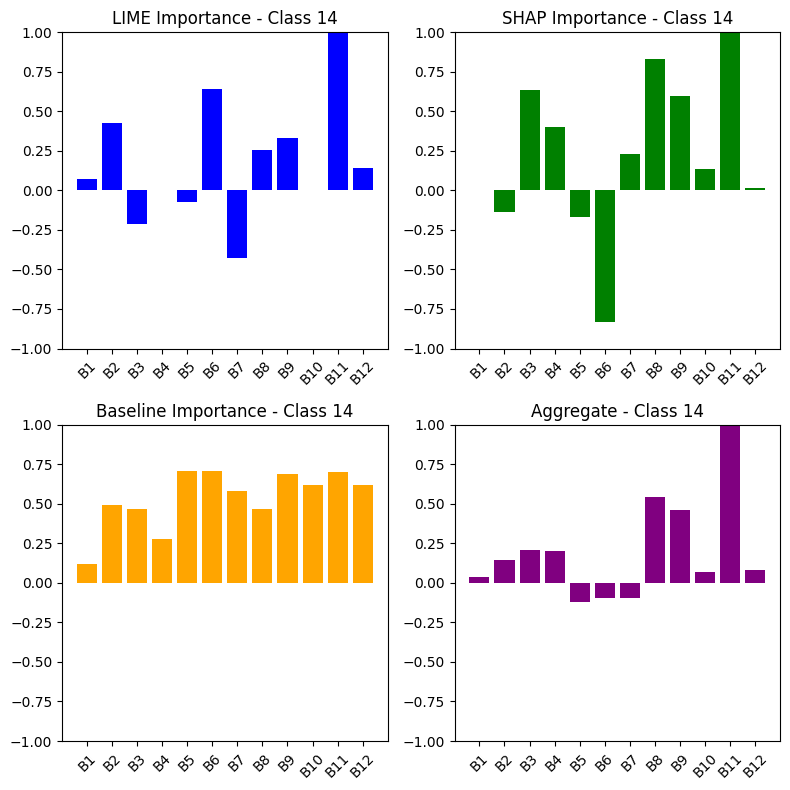

Spearman correlation (Avg vs Baseline): [0.5674264393540605, 0.22377622377622378, 0.013986013986013986, -0.30986683868975945, 0.3380365512979194, -0.12057950662162813, 0.29123216499055327, 0.5288974835954515, 0.35026323416917315, 0.26970269031026334, 0.32982659173657675, 0.49394166352926405, 0.22393984489839652, 0.38528955758609046, -0.2214442026860475]
RBO (Avg vs Baseline): [0.179388, 0.21981599999999993, 0.089694, 0.013121999999999998, 0.31981599999999993, 0.07146899999999999, 0.16604099999999997, 0.11593799999999999, 0.062694, 0.2616939999999999, 0.2616939999999999, 0.14781599999999998, 0.23469399999999996, 0.20616299999999999, 0.089694]
Jaccard Similarity (Avg vs Baseline): [0.6666666666666666, 0.42857142857142855, 0.25, 0.1111111111111111, 0.42857142857142855, 0.25, 0.42857142857142855, 0.6666666666666666, 0.25, 0.25, 0.25, 0.42857142857142855, 0.25, 0.6666666666666666, 0.25]
Spearman 0.224 ± 0.259
RBO 0.163 ± 0.085
Jaccard 0.372 ± 0.172

CLASS 15

F1-Base: 0.39

Top bands by LIM

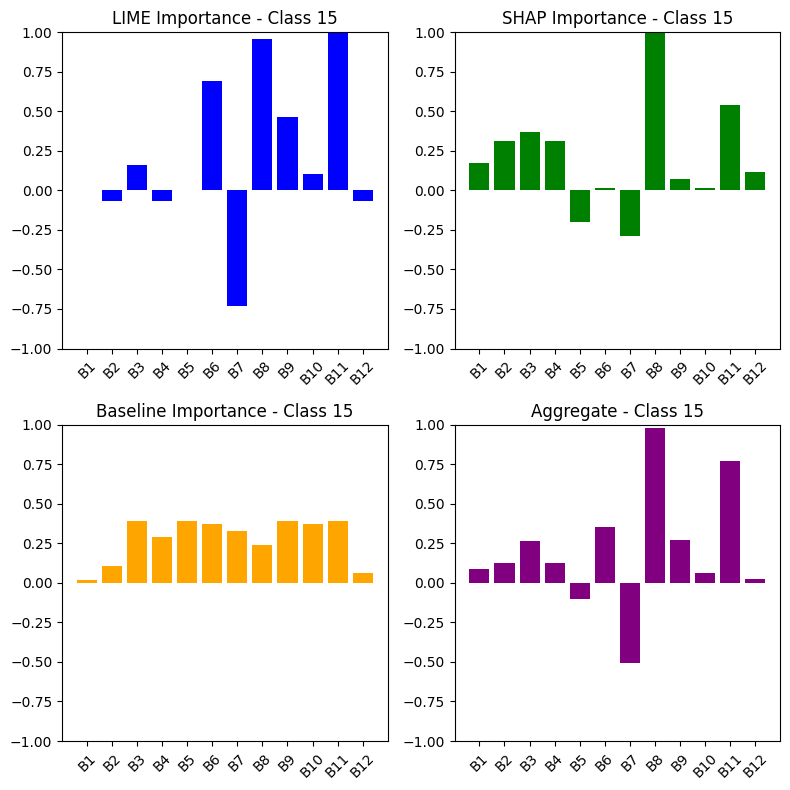

Spearman correlation (Avg vs Baseline): [0.5674264393540605, 0.22377622377622378, 0.013986013986013986, -0.30986683868975945, 0.3380365512979194, -0.12057950662162813, 0.29123216499055327, 0.5288974835954515, 0.35026323416917315, 0.26970269031026334, 0.32982659173657675, 0.49394166352926405, 0.22393984489839652, 0.38528955758609046, -0.2214442026860475, 0.21431988791072795]
RBO (Avg vs Baseline): [0.179388, 0.21981599999999993, 0.089694, 0.013121999999999998, 0.31981599999999993, 0.07146899999999999, 0.16604099999999997, 0.11593799999999999, 0.062694, 0.2616939999999999, 0.2616939999999999, 0.14781599999999998, 0.23469399999999996, 0.20616299999999999, 0.089694, 0.14781599999999998]
Jaccard Similarity (Avg vs Baseline): [0.6666666666666666, 0.42857142857142855, 0.25, 0.1111111111111111, 0.42857142857142855, 0.25, 0.42857142857142855, 0.6666666666666666, 0.25, 0.25, 0.25, 0.42857142857142855, 0.25, 0.6666666666666666, 0.25, 0.42857142857142855]
Spearman 0.224 ± 0.250
RBO 0.162 ± 0.082
J

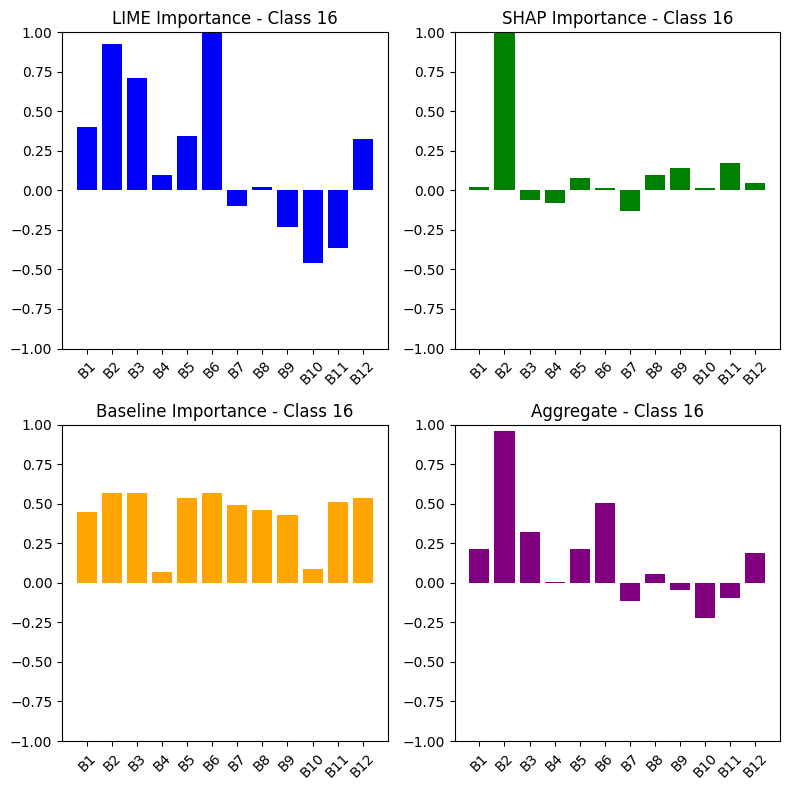

Spearman correlation (Avg vs Baseline): [0.5674264393540605, 0.22377622377622378, 0.013986013986013986, -0.30986683868975945, 0.3380365512979194, -0.12057950662162813, 0.29123216499055327, 0.5288974835954515, 0.35026323416917315, 0.26970269031026334, 0.32982659173657675, 0.49394166352926405, 0.22393984489839652, 0.38528955758609046, -0.2214442026860475, 0.21431988791072795, 0.7160772254706662]
RBO (Avg vs Baseline): [0.179388, 0.21981599999999993, 0.089694, 0.013121999999999998, 0.31981599999999993, 0.07146899999999999, 0.16604099999999997, 0.11593799999999999, 0.062694, 0.2616939999999999, 0.2616939999999999, 0.14781599999999998, 0.23469399999999996, 0.20616299999999999, 0.089694, 0.14781599999999998, 0.23316299999999995]
Jaccard Similarity (Avg vs Baseline): [0.6666666666666666, 0.42857142857142855, 0.25, 0.1111111111111111, 0.42857142857142855, 0.25, 0.42857142857142855, 0.6666666666666666, 0.25, 0.25, 0.25, 0.42857142857142855, 0.25, 0.6666666666666666, 0.25, 0.42857142857142855, 0

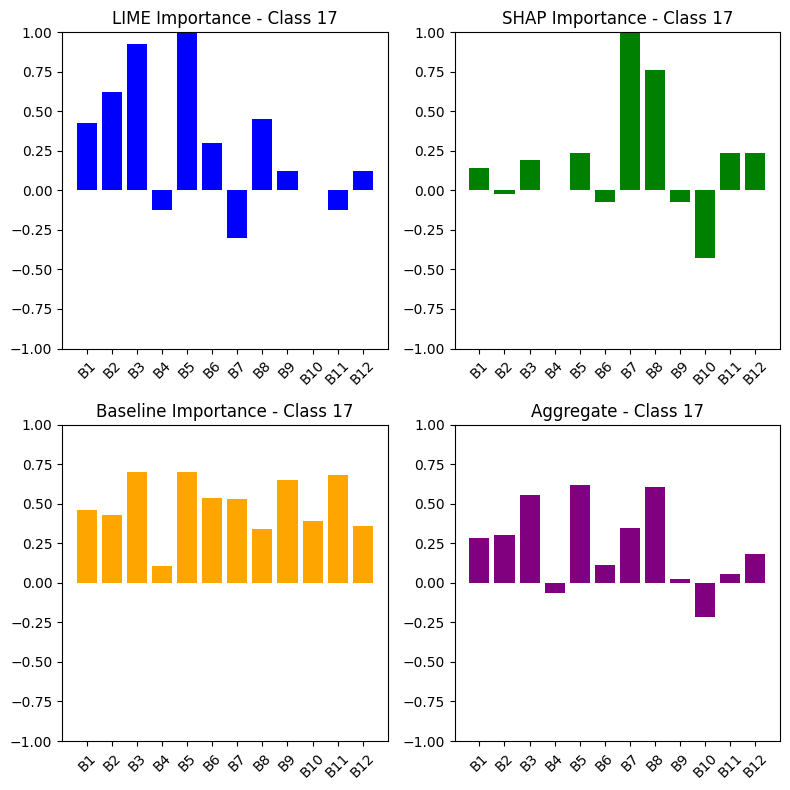

Spearman correlation (Avg vs Baseline): [0.5674264393540605, 0.22377622377622378, 0.013986013986013986, -0.30986683868975945, 0.3380365512979194, -0.12057950662162813, 0.29123216499055327, 0.5288974835954515, 0.35026323416917315, 0.26970269031026334, 0.32982659173657675, 0.49394166352926405, 0.22393984489839652, 0.38528955758609046, -0.2214442026860475, 0.21431988791072795, 0.7160772254706662, 0.3082316460688724]
RBO (Avg vs Baseline): [0.179388, 0.21981599999999993, 0.089694, 0.013121999999999998, 0.31981599999999993, 0.07146899999999999, 0.16604099999999997, 0.11593799999999999, 0.062694, 0.2616939999999999, 0.2616939999999999, 0.14781599999999998, 0.23469399999999996, 0.20616299999999999, 0.089694, 0.14781599999999998, 0.23316299999999995, 0.2616939999999999]
Jaccard Similarity (Avg vs Baseline): [0.6666666666666666, 0.42857142857142855, 0.25, 0.1111111111111111, 0.42857142857142855, 0.25, 0.42857142857142855, 0.6666666666666666, 0.25, 0.25, 0.25, 0.42857142857142855, 0.25, 0.666666

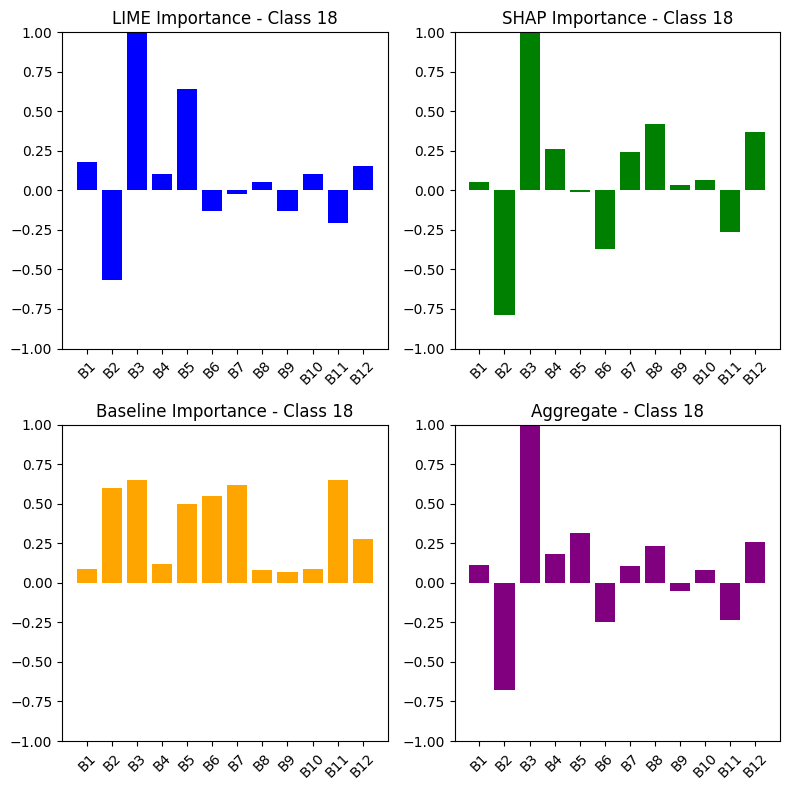

Spearman correlation (Avg vs Baseline): [0.5674264393540605, 0.22377622377622378, 0.013986013986013986, -0.30986683868975945, 0.3380365512979194, -0.12057950662162813, 0.29123216499055327, 0.5288974835954515, 0.35026323416917315, 0.26970269031026334, 0.32982659173657675, 0.49394166352926405, 0.22393984489839652, 0.38528955758609046, -0.2214442026860475, 0.21431988791072795, 0.7160772254706662, 0.3082316460688724, -0.059649489994912826]
RBO (Avg vs Baseline): [0.179388, 0.21981599999999993, 0.089694, 0.013121999999999998, 0.31981599999999993, 0.07146899999999999, 0.16604099999999997, 0.11593799999999999, 0.062694, 0.2616939999999999, 0.2616939999999999, 0.14781599999999998, 0.23469399999999996, 0.20616299999999999, 0.089694, 0.14781599999999998, 0.23316299999999995, 0.2616939999999999, 0.10334699999999997]
Jaccard Similarity (Avg vs Baseline): [0.6666666666666666, 0.42857142857142855, 0.25, 0.1111111111111111, 0.42857142857142855, 0.25, 0.42857142857142855, 0.6666666666666666, 0.25, 0.2

In [4]:
import numpy as np
from scipy.stats import spearmanr, kendalltau
import matplotlib.pyplot as plt
import rbo
import seaborn as sns

# Band labels
bands = [f'B{i+1}' for i in range(12)]

f1_base = [0.88, 0.85, 0.89, 0.67, 0.73, 0.58, 0.54, 0.79, 0.81, 0.89,
           0.98, 0.84, 0.73, 0.67, 0.71, 0.39, 0.57, 0.70, 0.68]

sign_score_lime_shaps = []

spearmanrs_lime_shaps = []
spearmanrs_lime_base = []
spearmanrs_shap_base = []

rbo_lime_shaps = []

jaccard_top5_lime_shap = []

avg_plots_lime_shaps = []

# Arrays to store metrics between avg_baseline
spearman_list = []
rbo_list = []
jaccard_list = []

# kendalls_lime_shaps = []
# kendalls_lime_base = []
# kendalls_shap_base = []

# Dữ liệu cho nhiều class
all_lime = [
    [-0.03, -0.1, 0.095, 0.03, -0.15, -0.05, 0.2, 0.25, 0.07, -0.06, -0.08, 0.12],
    [0.02, 0.07, -0.07, 0.005, -0.05, -0.02, 0.001, 0.11, 0.08, -0.01, 0.09, -0.045],
    [0.01, 0.02, -0.01, 0.01, -0.01, 0.06, 0.005, 0.07, 0.01, -0.02, 0.01, -0.005],
    [0.002, 0.003, -0.004, 0.013, 0.012, -0.007, -0.008, 0.012, 0.011, 0.002, 0.014, -0.0025],
    [0.035, 0.001, -0.09, 0.02, 0.001, -0.005, -0.03, 0.10, 0.11, -0.02, 0.14, -0.14],
    [0.005, -0.005, 0.012, 0.005, -0.005, 0.0, 0.002, 0.017, 0.005, 0.002, 0.006, 0.006],
    [-0.003, -0.007, 0.017, 0.007, -0.006, -0.0045, 0.006, 0.007, 0.001, 0.003, 0.006, 0.0125],
    [-0.005, 0.01, 0.0005, 0.015, -0.02, -0.08, 0.02, 0.12, 0.04, 0.025, 0.07, -0.01],
    [0.01, 0.0755, -0.015, 0.018, -0.03, 0.02, 0.017, 0.01, -0.005, -0.01, 0.0375, -0.0025],

    [0.01, 0.025, 0.11, -0.01, -0.06, -0.04, 0.005, 0.05, 0.005, 0.15, 0.045, 0.02],
    [0.21, 0.49, -0.04, 0.02, 0.16, 0.005, -0.04, -0.02, -0.009, 0.005, -0.01, -0.005],
    [-0.005, 0.006, 0.017, 0.016, -0.006, 0.011, -0.001, -0.002, -0.001, 0.004, 0.012, 0.02],
    [-0.008, 0.004, 0.003, 0.009, -0.019, -0.005, 0.005, 0.007, 0.004, 0.002, 0.018, 0.017],
    [-0.02, 0.06, -0.005, -0.005, 0.01, -0.11, -0.09, -0.02, 0.09, 0.14, 0.11, 0.005],
    [0.005, 0.03, -0.015, 0.0, -0.005, 0.045, -0.03, 0.018, 0.023, 0.0, 0.07, 0.01],
    [0.0, -0.005, 0.012, -0.005, 0.0, 0.052, -0.055, 0.072, 0.035, 0.008, 0.0751, -0.005],
    [0.021, 0.048, 0.037, 0.005, 0.018, 0.052, -0.005, 0.001, -0.012, -0.024, -0.019, 0.017],
    [0.017, 0.025, 0.037, -0.005, 0.04, 0.012, -0.012, 0.018, 0.005, 0.0, -0.005, 0.005],
    [0.07, -0.22, 0.39, 0.04, 0.25, -0.05, -0.01, 0.02, -0.05, 0.04, -0.08, 0.06]
    # Add more
]
all_shap = [
    [-0.07, -0.06, 0.48, 0.13, -0.13, -0.3, 0.4, 0.19, -0.12, 0.075, -0.08, 0.31],
    [0.04, -0.03, 0.14, 0.05, 0.03, -0.33, -0.02, 0.31, 0.2, 0.06, 0.03, 0.29],
    [-0.02, -0.15, 0.38, 0.085, 0.001, -0.37, -0.21, 0.27, 0.37, 0.15, 0.4, -0.05],
    [-0.0001, -0.01, 0.28, 0.08, -0.06, -0.18, 0.13, 0.25, -0.0015, -0.02, 0.05, 0.1],
    [-0.05, -0.16, 0.3, 0.14, -0.12, -0.42, 0.05, 0.28, 0.26, 0.18, 0.65, -0.25],
    [-0.01, -0.015, 0.29, 0.08, -0.03, -0.26, 0.09, 0.25, 0.01, 0.07, 0.03, 0.16],
    [0.0, 0.005, 0.25, 0.06, -0.08, -0.22, 0.05, 0.19, 0.055, 0.04, 0.18, 0.12],
    [-0.001, 0.02, 0.25, 0.05, -0.18, -0.3, 0.32, 0.44, 0.0005, 0.03, 0.04, 0.15],
    [0.02, 0.28, 0.12, 0.04, -0.11, 0.03, 0.09, 0.27, -0.2, -0.04, -0.06, 0.25],

    [0.001, 0.17, 0.001, 0.0005, -0.28, -0.16, 0.2, 0.5, 0.28, -0.05, 0.18, 0.1],
    [-0.002, 0.03, 0.15, 0.04, -0.5, -0.57, 0.38, 0.48, 0.32, 0.15, 0.37, 0.16],
    [-0.12, 0.1, 0.3, 0.4, -0.5, -0.23, 0.22, 0.03, -0.1, 0.05, 0.5, 0.18],
    [-0.01, -0.41, 0.62, 0.21, 0.18, -0.21, 0.04, 0.21, 0.06, 0.05, -0.22, 0.33],
    [-0.01, -0.005, 0.3, 0.12, 0.0, -0.34, -0.02, 0.19, 0.2, 0.18, 0.21, 0.05],
    [0.0, -0.04, 0.19, 0.12, -0.05, -0.25, 0.07, 0.25, 0.18, 0.04, 0.3, 0.005],
    [0.06, 0.11, 0.13, 0.11, -0.07, 0.005, -0.1, 0.35, 0.025, 0.005, 0.19, 0.04],
    [0.015, 0.63, -0.04, -0.05, 0.05, 0.01, -0.08, 0.06, 0.09, 0.01, 0.11, 0.03],
    [0.06, -0.01, 0.08, 0.0, 0.1, -0.03, 0.42, 0.32, -0.03, -0.18, 0.1, 0.1],
    [0.05, -0.75, 0.95, 0.25, -0.01, -0.35, 0.23, 0.4, 0.03, 0.06, -0.25, 0.35]
    # Add more
]
all_baseline = [
    [0.87, 0.76, 0.02, 0.79, 0.72, 0.69, 0.24, 0.49, 0.68, 0.79, 0.6, 0.15],
    [0.72, 0.56, 0.39, 0.78, 0.51, 0.18, 0.06, 0.02, 0.0, 0.41, 0.29, 0.47],
    [0.86, 0.67, 0.06, 0.88, 0.17, 0.00, 0.07, 0.34, 0.02, 0.79, 0.38, 0.48],
    [0.58, 0.26, 0.00, 0.54, 0.00, 0.00, 0.01, 0.32, 0.14, 0.19, 0.08, 0.07],
    [0.63, 0.33, 0.32, 0.47, 0.17, 0.01, 0.00, 0.14, 0.00, 0.31, 0.00, 0.37],
    [0.49, 0.15, 0.00, 0.41, 0.00, 0.00, 0.02, 0.04, 0.04, 0.04, 0.03, 0.08],
    [0.32, 0.05, 0.0, 0.22, 0.0, 0.0, 0.0, 0.0, 0.01, 0.0, 0.0, 0.0],
    [0.76, 0.56, 0.0, 0.75, 0.02, 0.52, 0.04, 0.11, 0.01, 0.2, 0.0, 0.1],
    [0.69, 0.14, 0.02, 0.75, 0.5, 0.01, 0.02, 0.38, 0.51, 0.63, 0.1, 0.04],

    [0.73, 0.54, 0.65, 0.88, 0.71, 0.75, 0.67, 0.5, 0.79, 0.76, 0.78, 0.67],
    [0.6, 0.31, 0.68, 0.98, 0.73, 0.76, 0.76, 0.77, 0.95, 0.95, 0.5, 0.94],
    [0.79, 0.11, 0.0, 0.17, 0.05, 0.0, 0.0, 0.75, 0.7, 0.13, 0.0, 0.0],
    [0.59, 0.24, 0.0, 0.16, 0.0, 0.0, 0.0, 0.0, 0.09, 0.15, 0.01, 0.0],
    [0.67, 0.33, 0.1, 0.44, 0.16, 0.21, 0.09, 0.45, 0.02, 0.16, 0.08, 0.18],
    [0.59, 0.22, 0.24, 0.43, 0.0, 0.0, 0.13, 0.24, 0.02, 0.09, 0.01, 0.09],
    [0.37, 0.28, 0.0, 0.1, 0.0, 0.02, 0.06, 0.15, 0.0, 0.02, 0.0, 0.33],
    [0.12, 0.0, 0.0, 0.5, 0.03, 0.0, 0.08, 0.11, 0.14, 0.48, 0.06, 0.03],
    [0.24, 0.27, 0.0, 0.59, 0.0, 0.16, 0.17, 0.36, 0.05, 0.31, 0.02, 0.34],
    [0.59, 0.08, 0.03, 0.56, 0.18, 0.13, 0.06, 0.6, 0.61, 0.59, 0.03, 0.4]
    # Add more
]

# ======================== Hàm phụ ========================
def top_k_indices(values, k=5, reverse=True):
    return np.argsort(values)[::-1 if reverse else 1][:k]

def jaccard_similarity(list1, list2):
    set1, set2 = set(list1), set(list2)
    return len(set1 & set2) / len(set1 | set2)

def same_sign_score(arr1, arr2):
    score = 0
    for a, b in zip(arr1, arr2):
        if a == 0 or b == 0:
            continue
        if (a > 0 and b > 0) or (a < 0 and b < 0):
            score += 1
    return score/12
def normalize_to_neg1_pos1(arr):
    max_abs = np.max(np.abs(arr))
    if max_abs == 0:
        return arr  # tránh chia 0
    return arr / max_abs


intersection_ratios = []
baseline_importances = []
# ======================== Vòng lặp các class ========================
for i, (lime_importance, shap_importance, baseline_importance) in enumerate(zip(all_lime, all_shap, all_baseline), start=0):
    print("="*80)
    print(f"\nCLASS {i}")
    print(f"\nF1-Base: {f1_base[i]}")

    baseline_importance = [f1_base[i] - val for val in baseline_importance]
    baseline_importances.append(baseline_importance)

    # Top-K band names
    top_lime_idx = top_k_indices(lime_importance)
    top_shap_idx = top_k_indices(shap_importance)
    top_base_idx = top_k_indices(baseline_importance)

    top_lime = [bands[j] for j in top_lime_idx]
    top_shap = [bands[j] for j in top_shap_idx]
    top_base = [bands[j] for j in top_base_idx]

    print(f"\nTop bands by LIME:     {top_lime}")
    print(f"Top bands by SHAP:     {top_shap}")
    print(f"Top bands by Baseline (low → important): {top_base}")

    # Same-sign score
    sign_score_lime_shap = same_sign_score(lime_importance, shap_importance)
    sign_score_lime_shaps.append(sign_score_lime_shap)
    print(f"\nSame-Sign Score (LIME vs SHAP):     {sign_score_lime_shap}")

    # Tính Spearman
    rho_lime_shap, _ = spearmanr(lime_importance, shap_importance)
    rho_lime_base, _ = spearmanr(lime_importance, baseline_importance)
    rho_shap_base, _ = spearmanr(shap_importance, baseline_importance)

    spearmanrs_lime_shaps.append(rho_lime_shap)
    spearmanrs_lime_base.append(rho_lime_base)
    spearmanrs_shap_base.append(rho_shap_base)

    print(f"\nSpearman correlation (LIME vs SHAP):     {rho_lime_shap:.3f}")
    print(f"Spearman correlation (LIME vs Baseline): {rho_lime_base:.3f}")
    print(f"Spearman correlation (SHAP vs Baseline): {rho_shap_base:.3f}")

    # RBO
    rbo_lime_shap = rbo.RankingSimilarity(top_lime, top_shap).rbo(p=0.9)
    rbo_lime_base = rbo.RankingSimilarity(top_lime, top_base).rbo(p=0.9)
    rbo_shap_base = rbo.RankingSimilarity(top_shap, top_base).rbo(p=0.9)
    rbo_lime_shaps.append(rbo_lime_shap)

    print(f"\nRBO (LIME vs SHAP):     {rbo_lime_shap:.3f}")
    print(f"RBO (LIME vs Baseline): {rbo_lime_base:.3f}")
    print(f"RBO (SHAP vs Baseline): {rbo_shap_base:.3f}")

    # Tính tỉ số Baseline ∩ (LIME ∪ SHAP)
    union_lime_shap = set(top_lime) | set(top_shap)
    intersect_base_union = set(top_base) & union_lime_shap
    ratio_intersect_over_union = len(intersect_base_union) / len(union_lime_shap)
    print(f"\nIntersection Ratio (Baseline ∩ (LIME ∪ SHAP)): {ratio_intersect_over_union:.3f}")
    intersection_ratios.append(ratio_intersect_over_union)
    # Jaccard
    jac_lime_shap = jaccard_similarity(top_lime, top_shap)
    jac_lime_base = jaccard_similarity(top_lime, top_base)
    jac_shap_base = jaccard_similarity(top_shap, top_base)

    jaccard_top5_lime_shap.append(jac_lime_shap)

    print(f"\nJaccard Similarity (LIME vs SHAP):     {jac_lime_shap:.3f}")
    print(f"Jaccard Similarity (LIME vs Baseline): {jac_lime_base:.3f}")
    print(f"Jaccard Similarity (SHAP vs Baseline): {jac_shap_base:.3f}")

    # -------------------------------- Visualization --------------------------------
    x = np.arange(len(bands))
    all_values = lime_importance + shap_importance + baseline_importance
    y_min = min(all_values) - 0.1
    y_max = max(all_values) + 0.1

    plt.figure(figsize=(8, 8))

    # Subplot 1
    plt.subplot(2, 2, 1)
    plt.bar(x, normalize_to_neg1_pos1(lime_importance), color='blue')
    plt.xticks(x, bands, rotation=45)
    plt.title(f'LIME Importance - Class {i}')
    plt.ylim(-1, 1)

    # Subplot 2
    plt.subplot(2, 2, 2)
    plt.bar(x, normalize_to_neg1_pos1(shap_importance), color='green')
    plt.xticks(x, bands, rotation=45)
    plt.title(f'SHAP Importance - Class {i}')
    plt.ylim(-1, 1)

    # Subplot 3
    plt.subplot(2, 2, 3)
    plt.bar(x, baseline_importance, color='orange')
    plt.xticks(x, bands, rotation=45)
    plt.title(f'Baseline Importance - Class {i}')
    plt.ylim(-1, 1)

    # Subplot 4
    avg_plot = (normalize_to_neg1_pos1(lime_importance) + normalize_to_neg1_pos1(shap_importance)) / 2
    avg_plots_lime_shaps.append(avg_plot)
    plt.subplot(2, 2, 4)
    plt.bar(x, avg_plot, color='purple')
    plt.xticks(x, bands, rotation=45)
    plt.title(f'Aggregate - Class {i}')
    plt.ylim(-1, 1)

    plt.tight_layout()
    plt.show()

        # Metrics for Avg Plot vs Baseline
    rho_avg_base, _ = spearmanr(avg_plot, baseline_importance)
    rbo_avg_base = rbo.RankingSimilarity(
        [bands[j] for j in top_k_indices(avg_plot)],
        top_base
    ).rbo(p=0.9)
    jac_avg_base = jaccard_similarity(
        [bands[j] for j in top_k_indices(avg_plot)],
        top_base
    )

    spearman_list.append(rho_avg_base)
    rbo_list.append(rbo_avg_base)
    jaccard_list.append(jac_avg_base)

    print(f"Spearman correlation (Avg vs Baseline): {spearman_list}")
    print(f"RBO (Avg vs Baseline): {rbo_list}")
    print(f"Jaccard Similarity (Avg vs Baseline): {jaccard_list}")
    print("Spearman {:.3f} ± {:.3f}".format(np.mean(spearman_list), np.std(spearman_list)))
    print("RBO {:.3f} ± {:.3f}".format(np.mean(rbo_list), np.std(rbo_list)))
    print("Jaccard {:.3f} ± {:.3f}".format(np.mean(jaccard_list), np.std(jaccard_list)))



In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# 1. Tạo mảng dữ liệu (19 classes x 12 bands)
data = np.array([
    [0.02, 0.00, 0.21, 0.10, 0.00, 0.01, 0.65, 0.46, 0.02, 0.00, 0.26, 0.69],
    [0.00, 0.03, 0.00, 0.00, 0.00, 0.00, 0.00, 0.63, 0.13, 0.00, 0.20, 0.00],
    [0.00, 0.05, 0.00, 0.03, 0.02, 0.01, 0.00, 0.55, 0.01, 0.00, 0.00, 0.00],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.00, 0.00, 0.00, 0.00],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.40, 0.38, 0.00, 0.35, 0.00],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.10, 0.00, 0.00, 0.00, 0.00],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    [0.00, 0.09, 0.00, 0.00, 0.00, 0.00, 0.00, 0.17, 0.00, 0.00, 0.00, 0.00],
    [0.00, 0.02, 0.00, 0.01, 0.00, 0.01, 0.00, 0.00, 0.00, 0.00, 0.06, 0.00],
    [0.22, 0.16, 0.22, 0.25, 0.06, 0.06, 0.29, 0.53, 0.30, 0.28, 0.12, 0.45],
    [0.03, 0.19, 0.03, 0.02, 0.05, 0.16, 0.00, 0.00, 0.00, 0.14, 0.03, 0.00],
    [0.00, 0.01, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.04, 0.00, 0.00, 0.07, 0.00],
    [0.00, 0.02, 0.00, 0.02, 0.00, 0.00, 0.00, 0.07, 0.02, 0.09, 0.11, 0.00],
    [0.00, 0.06, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.00, 0.00, 0.04, 0.00],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    [0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    [0.01, 0.01, 0.03, 0.11, 0.01, 0.05, 0.00, 0.00, 0.00, 0.07, 0.00, 0.00]
])

# 2. Chuẩn hóa bằng MinMaxScaler về [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
data_scaled = scaler.fit_transform(data)

# 3. Vẽ heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(data_scaled, annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels=[f"B{i+1}" for i in range(12)],
            yticklabels=[f"Class {i}" for i in range(19)])
plt.title("Heatmap of Band Importance per Class (MinMax Scaled [-1, 1])")
plt.xlabel("Spectral Bands")
plt.ylabel("Classes")
plt.tight_layout()
plt.show()


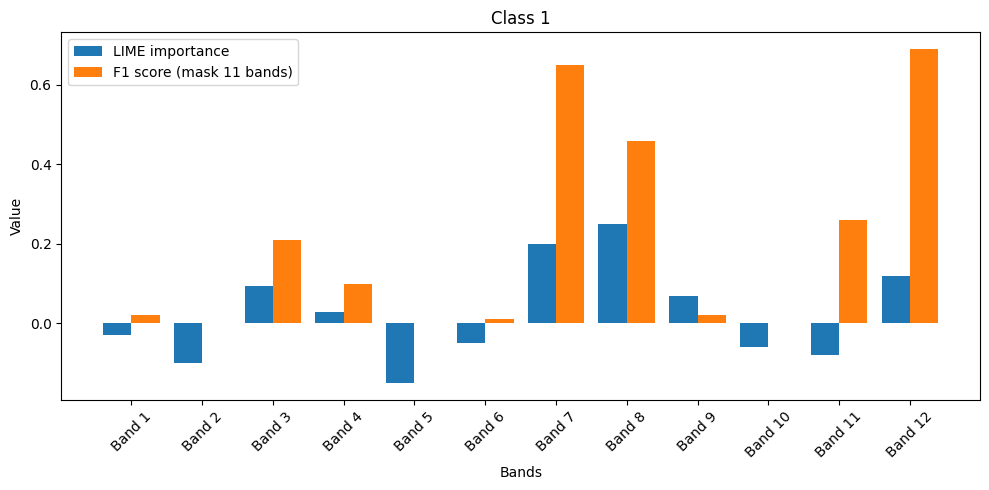

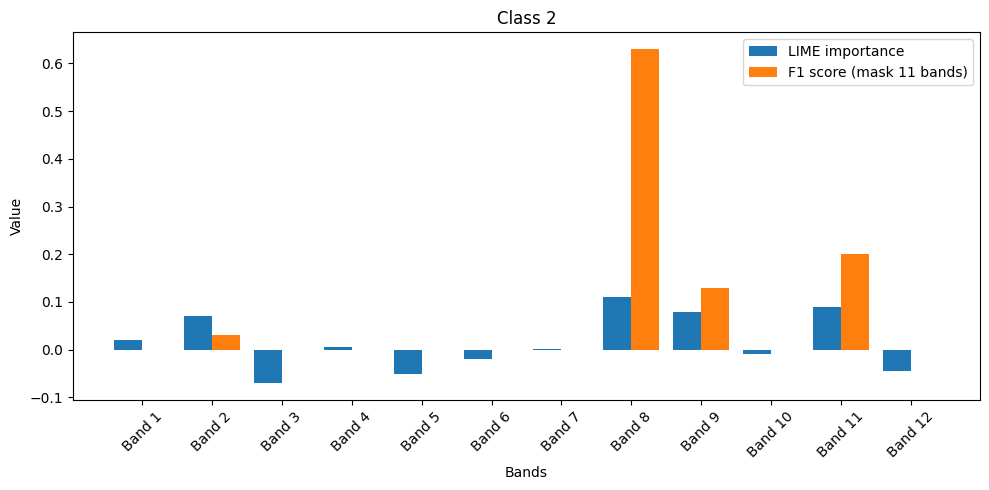

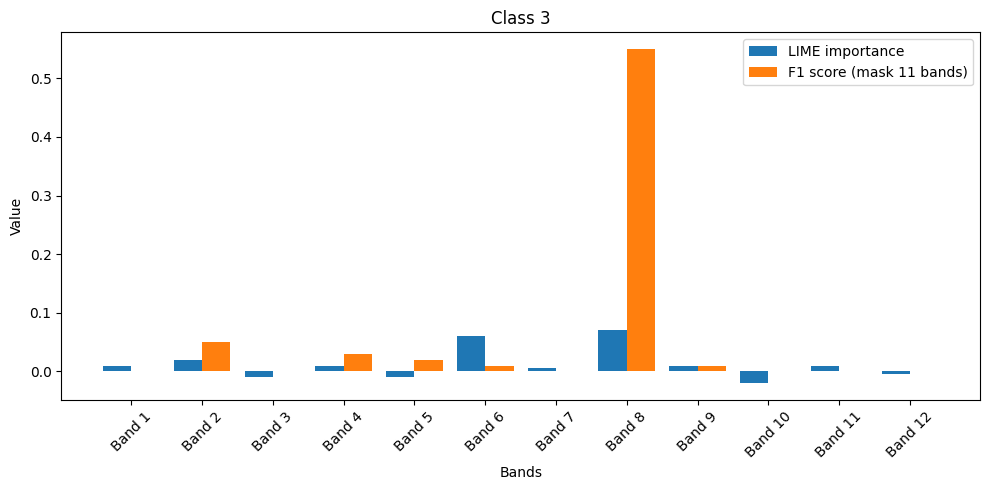

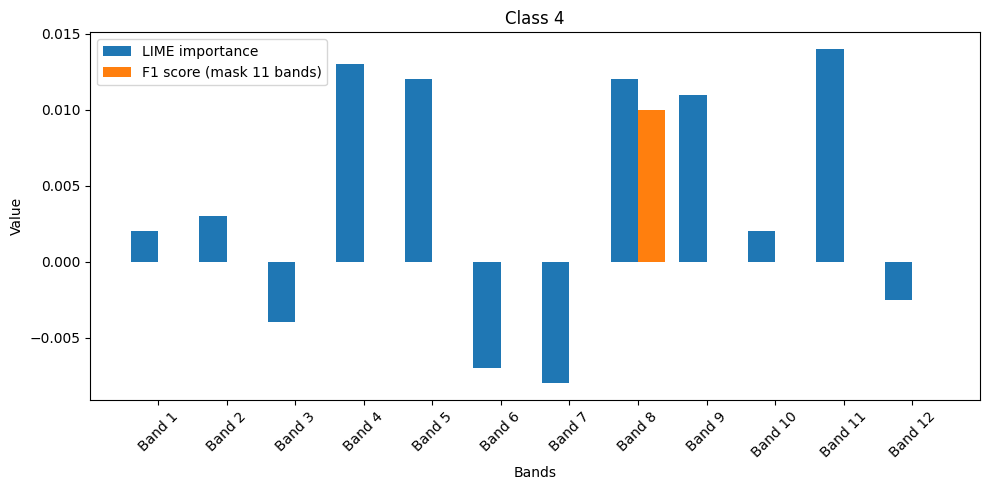

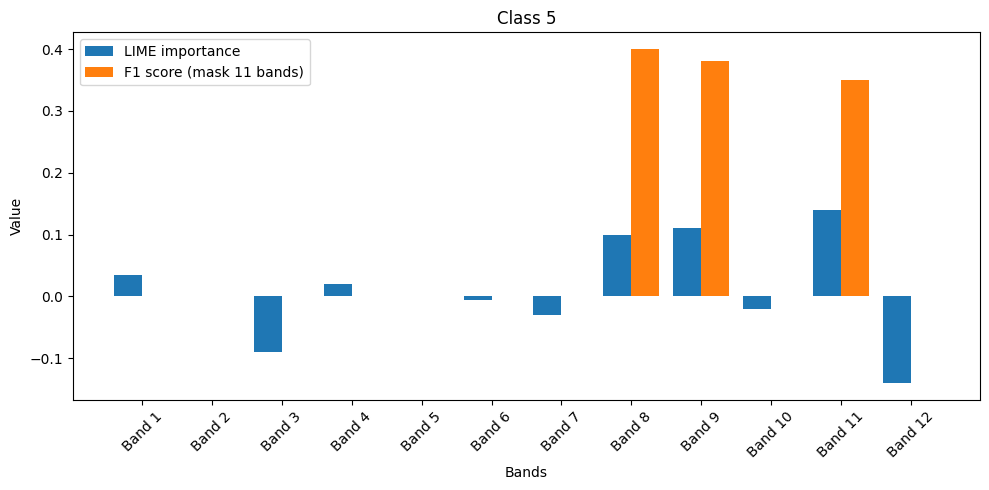

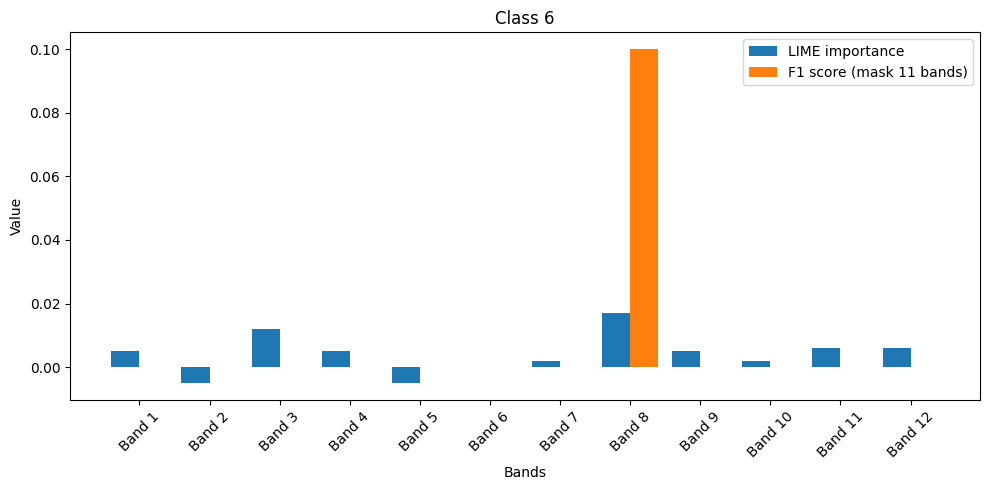

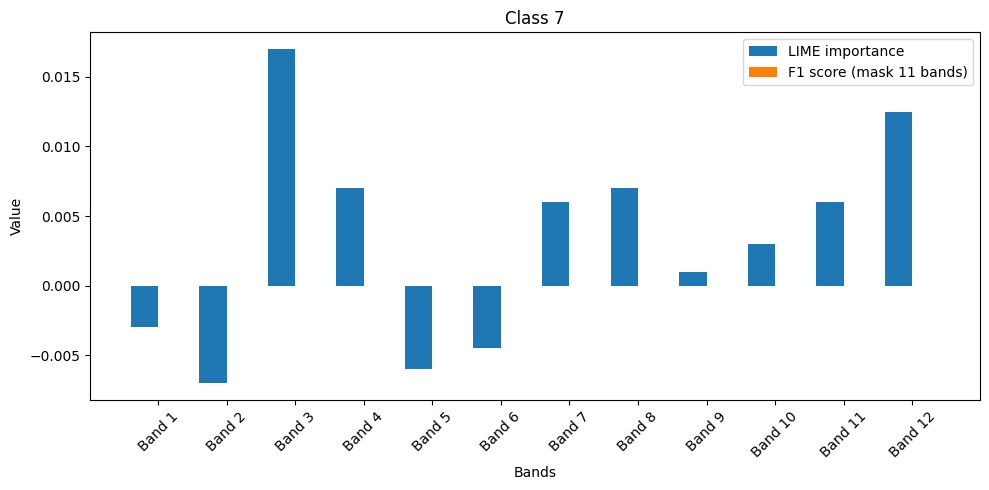

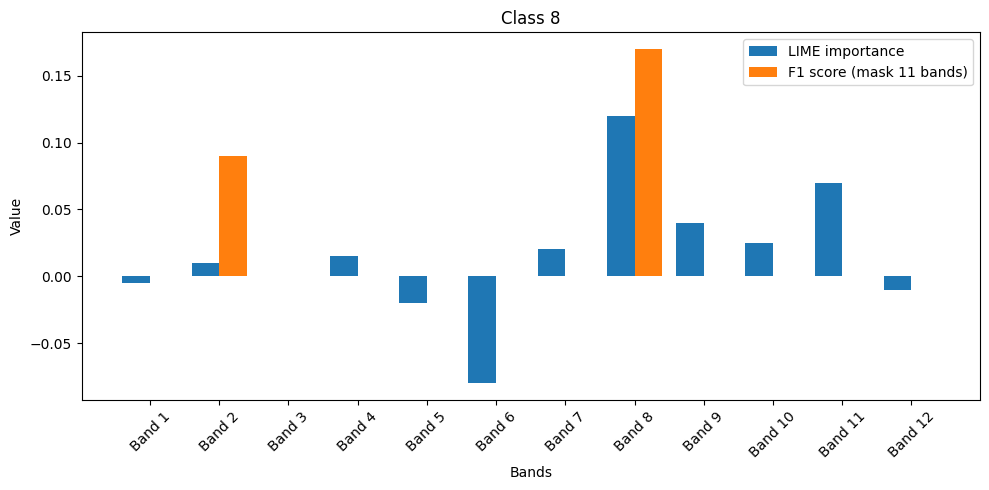

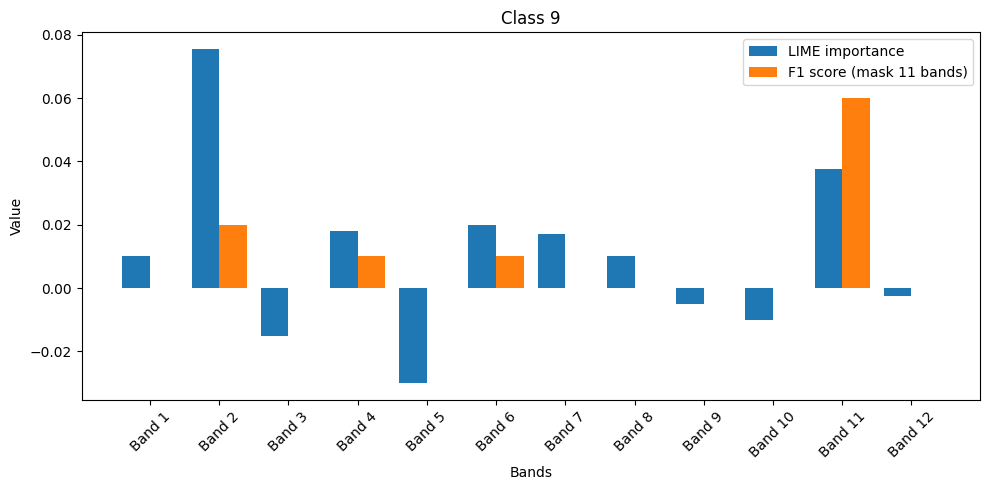

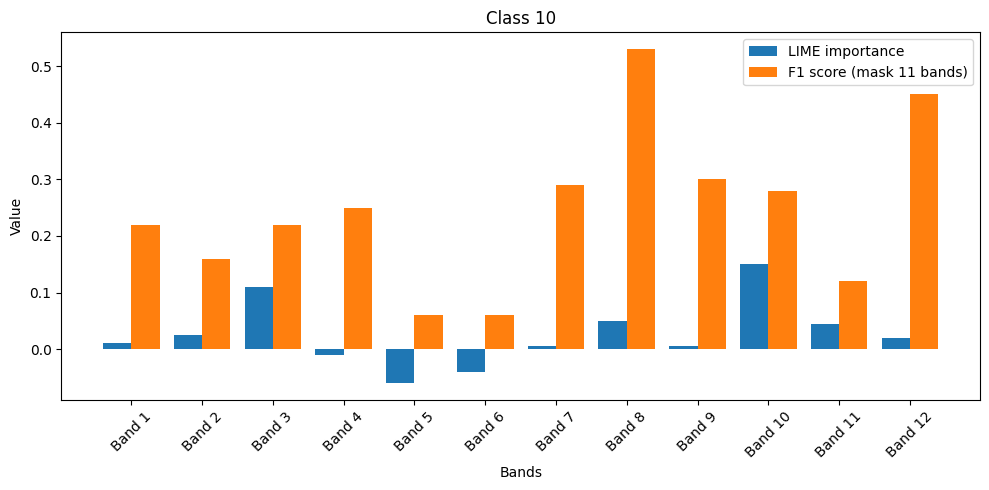

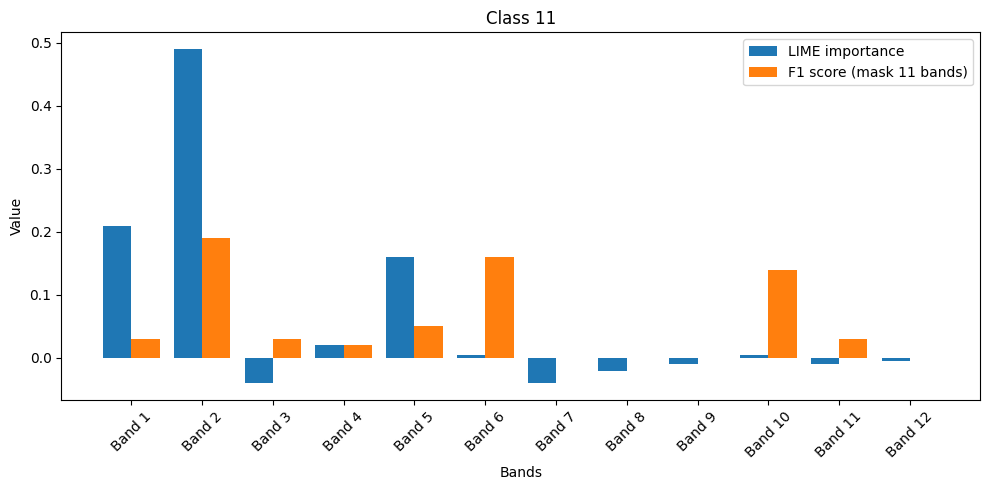

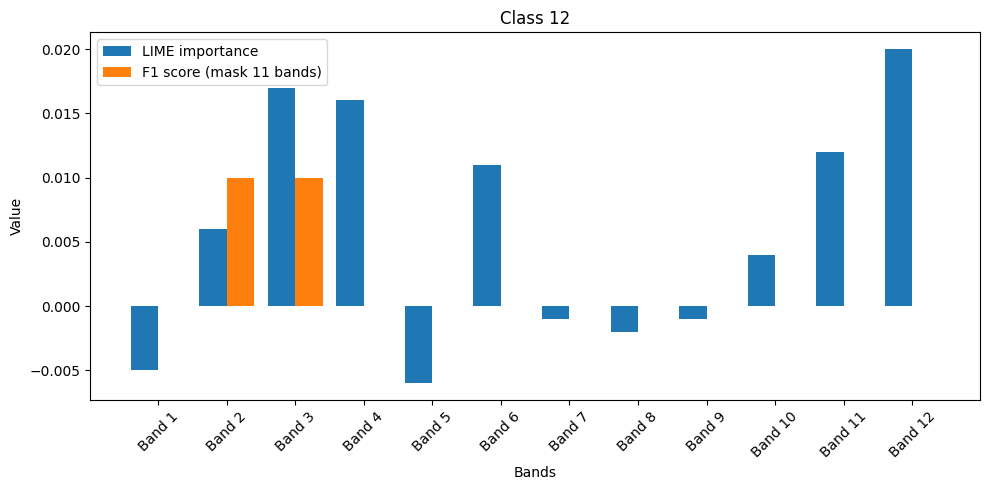

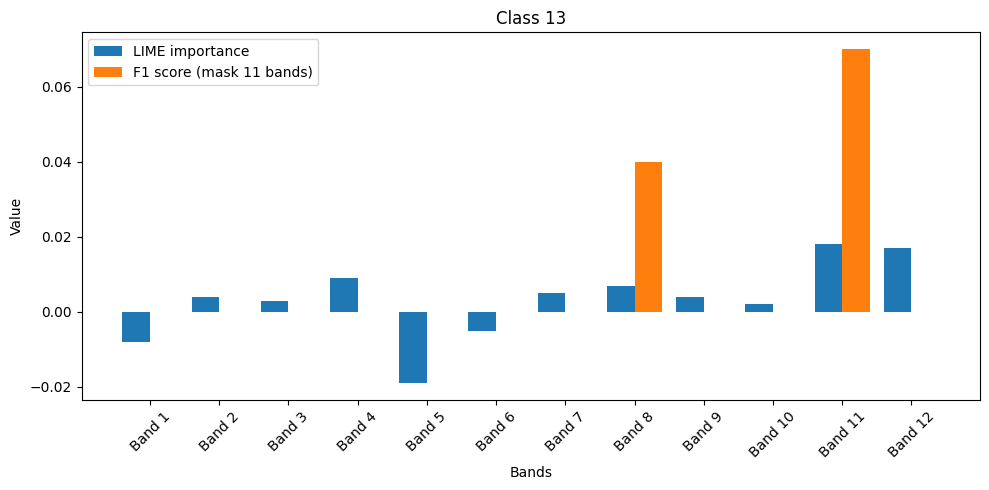

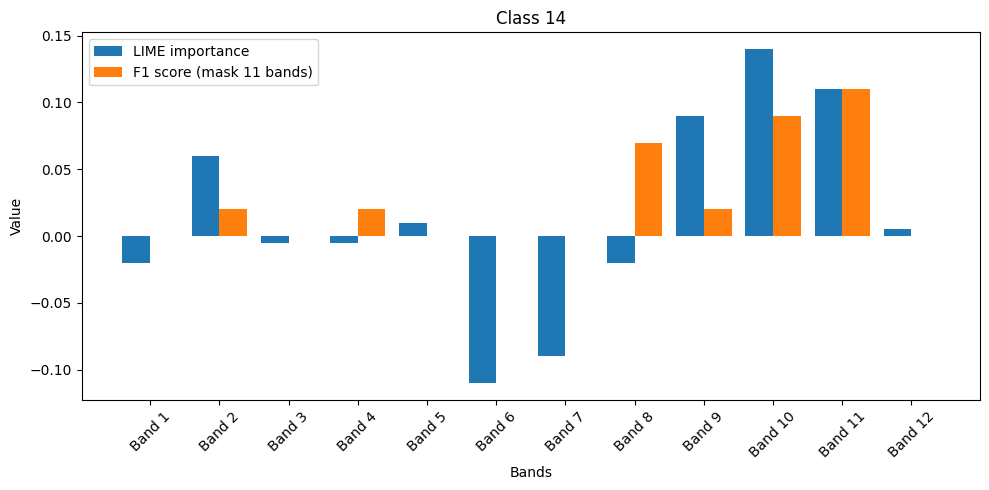

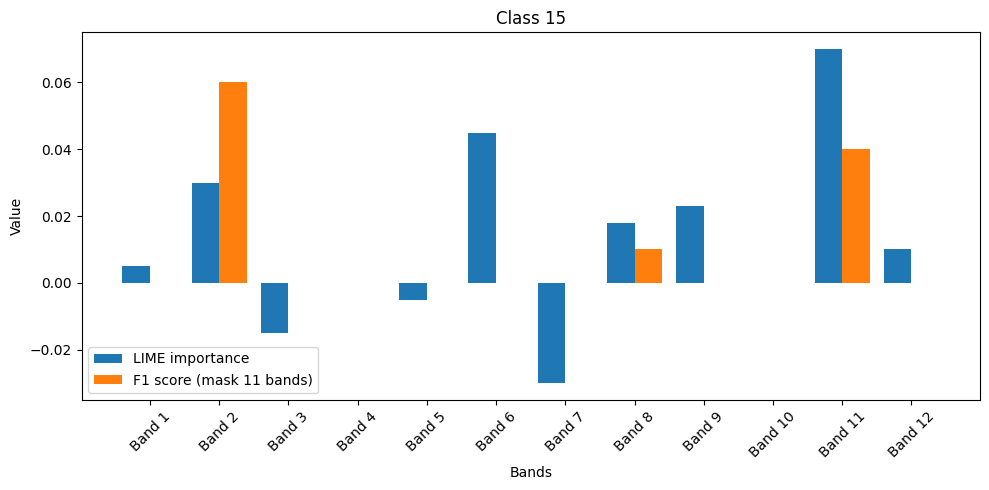

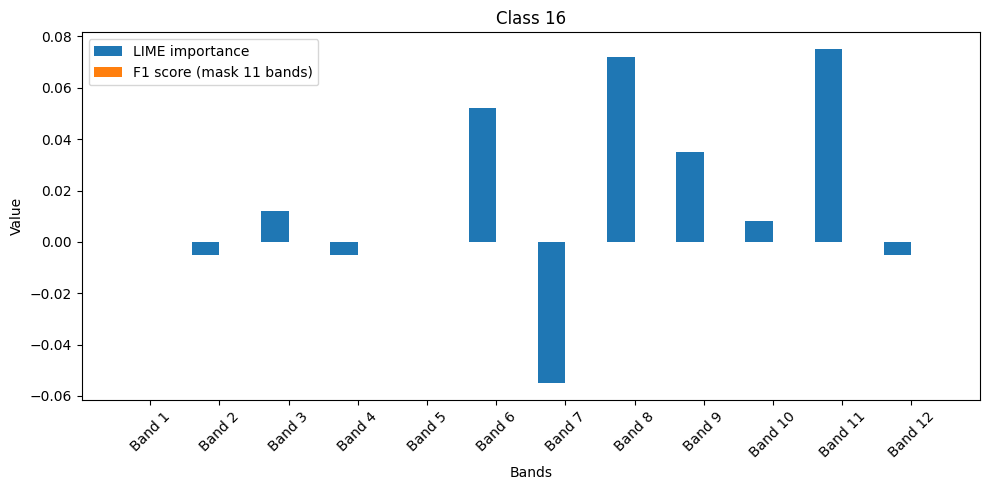

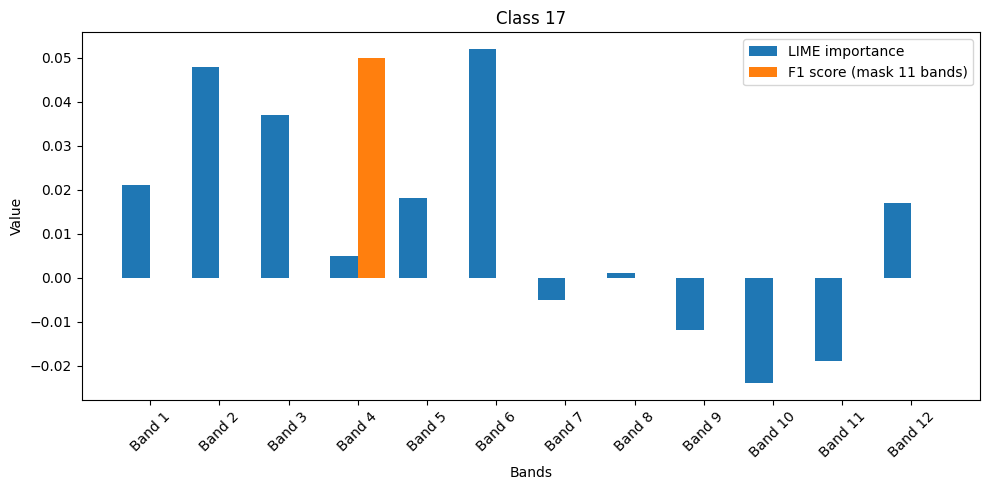

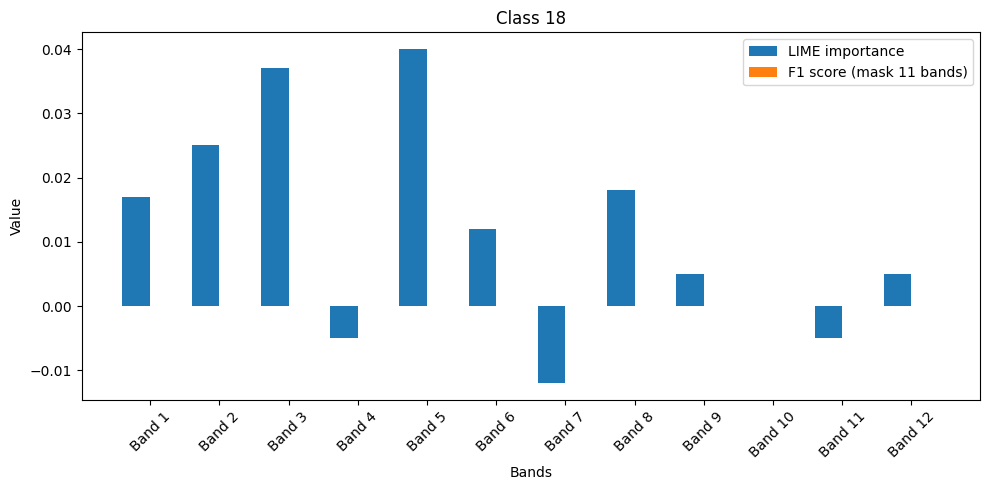

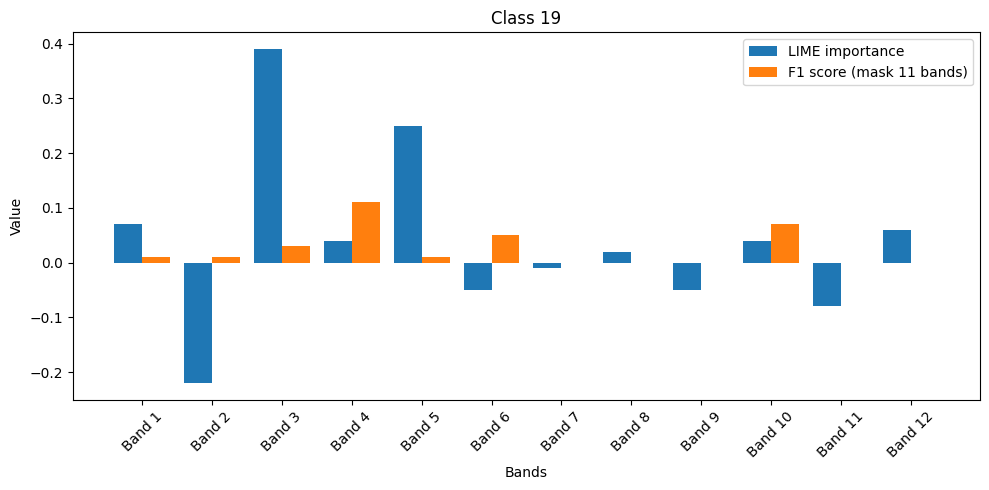

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Dữ liệu ----------
all_lime = [
    [-0.03, -0.1, 0.095, 0.03, -0.15, -0.05, 0.2, 0.25, 0.07, -0.06, -0.08, 0.12],
    [0.02, 0.07, -0.07, 0.005, -0.05, -0.02, 0.001, 0.11, 0.08, -0.01, 0.09, -0.045],
    [0.01, 0.02, -0.01, 0.01, -0.01, 0.06, 0.005, 0.07, 0.01, -0.02, 0.01, -0.005],
    [0.002, 0.003, -0.004, 0.013, 0.012, -0.007, -0.008, 0.012, 0.011, 0.002, 0.014, -0.0025],
    [0.035, 0.001, -0.09, 0.02, 0.001, -0.005, -0.03, 0.10, 0.11, -0.02, 0.14, -0.14],
    [0.005, -0.005, 0.012, 0.005, -0.005, 0.0, 0.002, 0.017, 0.005, 0.002, 0.006, 0.006],
    [-0.003, -0.007, 0.017, 0.007, -0.006, -0.0045, 0.006, 0.007, 0.001, 0.003, 0.006, 0.0125],
    [-0.005, 0.01, 0.0005, 0.015, -0.02, -0.08, 0.02, 0.12, 0.04, 0.025, 0.07, -0.01],
    [0.01, 0.0755, -0.015, 0.018, -0.03, 0.02, 0.017, 0.01, -0.005, -0.01, 0.0375, -0.0025],

    [0.01, 0.025, 0.11, -0.01, -0.06, -0.04, 0.005, 0.05, 0.005, 0.15, 0.045, 0.02],
    [0.21, 0.49, -0.04, 0.02, 0.16, 0.005, -0.04, -0.02, -0.009, 0.005, -0.01, -0.005],
    [-0.005, 0.006, 0.017, 0.016, -0.006, 0.011, -0.001, -0.002, -0.001, 0.004, 0.012, 0.02],
    [-0.008, 0.004, 0.003, 0.009, -0.019, -0.005, 0.005, 0.007, 0.004, 0.002, 0.018, 0.017],
    [-0.02, 0.06, -0.005, -0.005, 0.01, -0.11, -0.09, -0.02, 0.09, 0.14, 0.11, 0.005],
    [0.005, 0.03, -0.015, 0.0, -0.005, 0.045, -0.03, 0.018, 0.023, 0.0, 0.07, 0.01],
    [0.0, -0.005, 0.012, -0.005, 0.0, 0.052, -0.055, 0.072, 0.035, 0.008, 0.0751, -0.005],
    [0.021, 0.048, 0.037, 0.005, 0.018, 0.052, -0.005, 0.001, -0.012, -0.024, -0.019, 0.017],
    [0.017, 0.025, 0.037, -0.005, 0.04, 0.012, -0.012, 0.018, 0.005, 0.0, -0.005, 0.005],
    [0.07, -0.22, 0.39, 0.04, 0.25, -0.05, -0.01, 0.02, -0.05, 0.04, -0.08, 0.06]
    # Add more
]

data = np.array([
    [0.02, 0.00, 0.21, 0.10, 0.00, 0.01, 0.65, 0.46, 0.02, 0.00, 0.26, 0.69],
    [0.00, 0.03, 0.00, 0.00, 0.00, 0.00, 0.00, 0.63, 0.13, 0.00, 0.20, 0.00],
    [0.00, 0.05, 0.00, 0.03, 0.02, 0.01, 0.00, 0.55, 0.01, 0.00, 0.00, 0.00],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.00, 0.00, 0.00, 0.00],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.40, 0.38, 0.00, 0.35, 0.00],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.10, 0.00, 0.00, 0.00, 0.00],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    [0.00, 0.09, 0.00, 0.00, 0.00, 0.00, 0.00, 0.17, 0.00, 0.00, 0.00, 0.00],
    [0.00, 0.02, 0.00, 0.01, 0.00, 0.01, 0.00, 0.00, 0.00, 0.00, 0.06, 0.00],
    [0.22, 0.16, 0.22, 0.25, 0.06, 0.06, 0.29, 0.53, 0.30, 0.28, 0.12, 0.45],
    [0.03, 0.19, 0.03, 0.02, 0.05, 0.16, 0.00, 0.00, 0.00, 0.14, 0.03, 0.00],
    [0.00, 0.01, 0.01, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.04, 0.00, 0.00, 0.07, 0.00],
    [0.00, 0.02, 0.00, 0.02, 0.00, 0.00, 0.00, 0.07, 0.02, 0.09, 0.11, 0.00],
    [0.00, 0.06, 0.00, 0.00, 0.00, 0.00, 0.00, 0.01, 0.00, 0.00, 0.04, 0.00],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    [0.00, 0.00, 0.00, 0.05, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    [0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
    [0.01, 0.01, 0.03, 0.11, 0.01, 0.05, 0.00, 0.00, 0.00, 0.07, 0.00, 0.00]
])

all_lime = np.array(all_lime)

# ---------- Vẽ biểu đồ ----------
bands = np.arange(1, 13)
x = np.arange(len(bands))
width = 0.4

for i in range(19):
    plt.figure(figsize=(10,5))
    plt.bar(x - width/2, all_lime[i], width, label="LIME importance")
    plt.bar(x + width/2, data[i], width, label="F1 score (mask 11 bands)")
    
    plt.xticks(x, [f"Band {b}" for b in bands], rotation=45)
    plt.xlabel("Bands")
    plt.ylabel("Value")
    plt.title(f"Class {i+1}")
    plt.legend()
    plt.tight_layout()
    plt.show()
